# Time Series Analysis
By Matthew Heino

### Purpose:
This is a Jupyter Notebook for the D213 assessment for Advanced Data Analysis. This notebook will be the only submission for this assessment.  There will be some additional files:

- The cleaned dataset (section C5) and the training and test (section D1) will be saved to CSVs files that will acccompany this submission.
- A PDF, the executed Jupyter Notebook, contains all the output from this notebook in PDF form. 

Concepts that will be explored in this notebook will be:

- Creation of a time series model.
- Data preparation 
- Data transformation,  transforming data into a form that can be used for time series model.

**Note:** Code that has references uses the APA citation can be found in sections G and H in this Jupyter Notebook as well as the Word document.

**Note:** The original code was produced in Spyder ver. 5.3.3 and copied into this notebook.  This original Python script will not be accompanying this submission, but can made available upon request.

# Background

The file used in the assessment contains time series data that was gathered time series data for the university hospital. The data is data for the revenue for the hospital for the first two years of operation. The file is composed of two columns:
1. Day - a day during the first two years of the hospital operation
2. Revenue - the revenue is in millions of dollars.
There are 731 rows in the dataset. This number of columns accounts for the first month of data where no revenue was recorded. 

The data is found in the following file:
- **medical_time_series.csv**

This is the file that will contain the raw data that is used for time series analysis. 

**Note:**  This file must be in the same directory if you plan to run this notebook.

# Part I: Research Question
This section will discuss the research question that is to be answered using the time series data that is provided by the university.  This section will discuss the goals of the data analysis.
This section will discuss the research question that is to be answered using the time series data that is provided by the university.  This section will discuss the goals of the data analysis.

## A1. Research Question.
The question that can be answered using the times series data provided by the university is the following:
- Is it possible to predict or forecast the daily revenues for the university hospital accurately and how do these predictions compare to what is observed in the data? 

## A2. Goal and Objectives of the Research 
The goal of the data analysis is to effectively predict the daily revenue of the university hospital. This goal is to be able to develop a model that can accurately predict future revenue for the hospital.


## Pre-assessment tasks:
        
        1. Read the data from the CSV.
        2. Get a feel for what the data contains. 
        3. Print some information about the dataframe. 

# Part II: Justification of Methodology

This section will discuss the assumptions that are inherent in time series data modeling. 

## B.  Assumptions of Time Series Data Modeling.

There are a few assumptions that are associated with time series data modeling. The assumptions are the following:

1. Time series data must be stationary. 
2. The data does not contain outliers or other anomalous data.
3. The data is univariate, reflecting a single variable to be modeled.
4. Past data points are indicative of the behavior of future data points.

In [1]:
# Import the appropriate libraries

import matplotlib.dates as mdt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.tsa.stattools as sts
import warnings

from matplotlib import pyplot
from pmdarima import auto_arima
from scipy import signal
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf


In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### Functions used in the assessment.

**NOTE:** The '#' is to make it easier to find the beginning and the end of each of the functions. 

In [3]:

def calc_dickey_fuller(rev_array : np.array) -> tuple:
    
    """ Method to calculate Dickey_Fuller values
    
    Parameters:
        rev_array (np.array): Array of revenue values.
     
    Returns:
        results_adfuller (tuple): Tuple with the results of the ADF 
        calculation.
        
    """
    
    results_adfuller = sts.adfuller(rev_array)

    return results_adfuller

###############################################################################

def cal_rolling_mean_std(ts_df : pd.DataFrame
                         , num_days= 31) ->  pd.DataFrame():
    
    """  Calculate the rilling mean and standard dviation for the dataframe.
         
         Parameters:
         -----------------
         ts_df(Dataframe):      Time series dataframe.
         num_days(int):         Number of days in the period.
         
         Returns:
         -----------------
         time_series(DataFrame):  A pandas dataframe with the time series data.
    
    """

    # Calculate the rolling mean for the Revenue column.
    ts_df['rolling_mean'] = ts_df['Revenue'].rolling(window=num_days).mean()
    
    # Calculate the rolling standard deviation for Revenue column.
    ts_df['rolling_std'] = ts_df['Revenue'].rolling(window=num_days).std()
    
    
    return ts_df


###############################################################################

def create_spectral_plt(dataframe, column, ax, i:int, graph_title:str
                        , legend_text:str) -> plt:
# (matplotlib.pyplot.semilogy — Matplotlib 3.8.2 Documentation, n.d.)
# (SciPy.Signal.Periodogram — SciPY V1.12.0 Manual, n.d.)

    """ Method to create a spectral density graph. 
    
    Parameters:
        dataframe (dataframe): Dataframe with the data.
        column(str): column name
        ax(): position
        i(int): index for the graph item
        graph_title(str): Title for the graph.
        legend_text:str Legend information
     
    Returns:
       None
        
    """
    
    f, Pxx = signal.periodogram(dataframe[column])
    ax[i].semilogy(f, Pxx, label=legend_text)
    ax[i].set_title(graph_title)
    ax[i].legend()
    
    return ax[i]

#########################################################################################

def print_results_tuple(result_tuple: tuple):
    
    """ Method to print Dickey_Fuller values
    
    Parameters:
        result_tuple (tuple): Array of revenue values.
     
    Returns:
       None
        
    """
    
    print("\nADF Statistic: \t %f" % result_tuple[0])
    print("p-value: \t %f" % result_tuple[1])
    print("Critical Values: \n")
    
    # Interate through the values in the remaining parts of the tuple.
    for key, value in result_tuple[4].items():
        print("\t%s: %.3f" % (key, value))

###############################################################################

def read_series_data(file_name : str, index='Day', new_index='Date'
                     , start_date_str=None
                     , freq='D') -> pd.DataFrame():
    
    """  Create a dataframe that contains the time series data that has 
         been read from a file.
         
         Parameters:
         -----------------
         file(str):             File name of the time series.
         index(str):            The initial index of the column.
         new_index(str):        New index name for the dataframe.
         start_date_str(str):   The start date for the dataframe.
         freq(char):            Frequncy ofthe time series.
         
         
         Returns:
         -----------------
         time_series(DataFrame):  A pandas dataframe with the time series data.
    
    """
    
    # Read the data from the CSV file
    time_series_df = pd.read_csv(file_name)
    
    
    # Convert the start date from a string to a TimeStamp.
    start_date = pd.to_datetime(start_date_str)
    
    # Convert the 'Day' column the appropriate format.
    time_series_df[index] = pd.to_timedelta(time_series_df[index] - 1
                                            , unit=freq) + start_date
    
    # Rename the column to reflect more accurately reflect the contents 
    # and the format (yyyy-mm-dd). 
    time_series_df.rename(columns={'Day': 'Date'}, inplace=True)
    
    # Reset the index for the dataframe to the Date column.
    time_series_df.set_index('Date', inplace=True)
    
    
    return time_series_df

###############################################################################

def test_stationarity(p_value : float, critical=0.05):
    
    """ Method to test for stationarity
    
    Parameters:
        p_value (float): The resultant p-value.
     
    Returns:
       None
        
    """
    
    if p_value <= critical:
        print("\nReject the null hypothesis H0, the data is stationary.")
    else:
        print("\nAccept the null hypothesis, the data is non-stationary. ")  

###############################################################################


###############################################################################

# Part III: Data Preparation
This section will discuss the data cleaning process as it pertains to the data that has been provided. 

## C1. Visualization of the Time Series

To plot the data as a time series graph. The index column that is currently numeric will need to be changed using the pandas **to_datetime** method. This method will return a **TimeStamp** object. Utilizing this method will make it easier to proceed with the other sections of this assessment. The current format of the data has the start day as 1 and the ending data as 731.  These values could be plotted as is, but this change of the index to the data is required for other sections of the assessment.  It makes logical sense to handle it here. 

There was no indication as to what the start date should be so the date is set to '2020-01-01'.  It is believed that this should be an issue going forward with other sections of the assessment. The start date is open to interpretation and this start date seems the most logical.

The "Day" column will then be converted to the date format. The pandas method **to_timedelta** will compute the days using the start date as the starting point. Arguments for this method are:

- dataframe column  = 'Day'
- unit = 'D' - for the unit.
- start_date - the start date 

Read in the data from the CSV file. This function will aslo transfor the datat into a more usable state.  A pandas dataframe will be returned from the function.

**Note:** There is an extra space in the file name.  This has not been changed and will be used as-is.  The file name will not be modified from what was provided.  

In [4]:
# Read in the data from the CSV file.
med_time_series_df = read_series_data(file_name='medical_time_series .csv'
                                      , start_date_str= '2020-01-01')


View some information about what is contained in the dataframe. 

- View the data types of the columns.
- Get the first and last five elements.

In [5]:
# Print some data about the returned data frame
med_time_series_df.info()

med_time_series_df.shape

med_time_series_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2020-01-01 to 2021-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


,Revenue
Date,
2020-01-01,0.000000
2020-01-02,-0.292356
2020-01-03,-0.327772
2020-01-04,-0.339987
2020-01-05,-0.124888


Create the rolling average for the medical time series data frame

In [6]:
# Drop the zero values from the dataframe.
med_time_series_df = med_time_series_df[med_time_series_df['Revenue'] != 0]

#print(med_time_series_df.head())

#print(med_time_series_df.describe())
#print(med_time_series_df.info())

In [7]:
# Create the rolling average for the medical time series data frame
med_time_series_df = cal_rolling_mean_std(med_time_series_df, num_days=30)


In [8]:
med_time_series_df

,Revenue,rolling_mean,rolling_std
Date,,,
2020-01-02,-0.292356,NaN,NaN
2020-01-03,-0.327772,NaN,NaN
2020-01-04,-0.339987,NaN,NaN
2020-01-05,-0.124888,NaN,NaN
2020-01-06,-0.491590,NaN,NaN
...,...,...,...
2021-12-27,15.722056,18.012356,1.573763
2021-12-28,15.865822,18.023220,1.557144
2021-12-29,15.708988,18.011543,1.573606


In [9]:
# Check for missing values in the frame.
print(med_time_series_df.isnull().any())


Revenue         False
rolling_mean     True
rolling_std      True
dtype: bool


Create the visualization to show the time series data.  The graph below shows the time series data after the day is converted to a date format. The method used was to **polyfit** and **polyld** methods.  

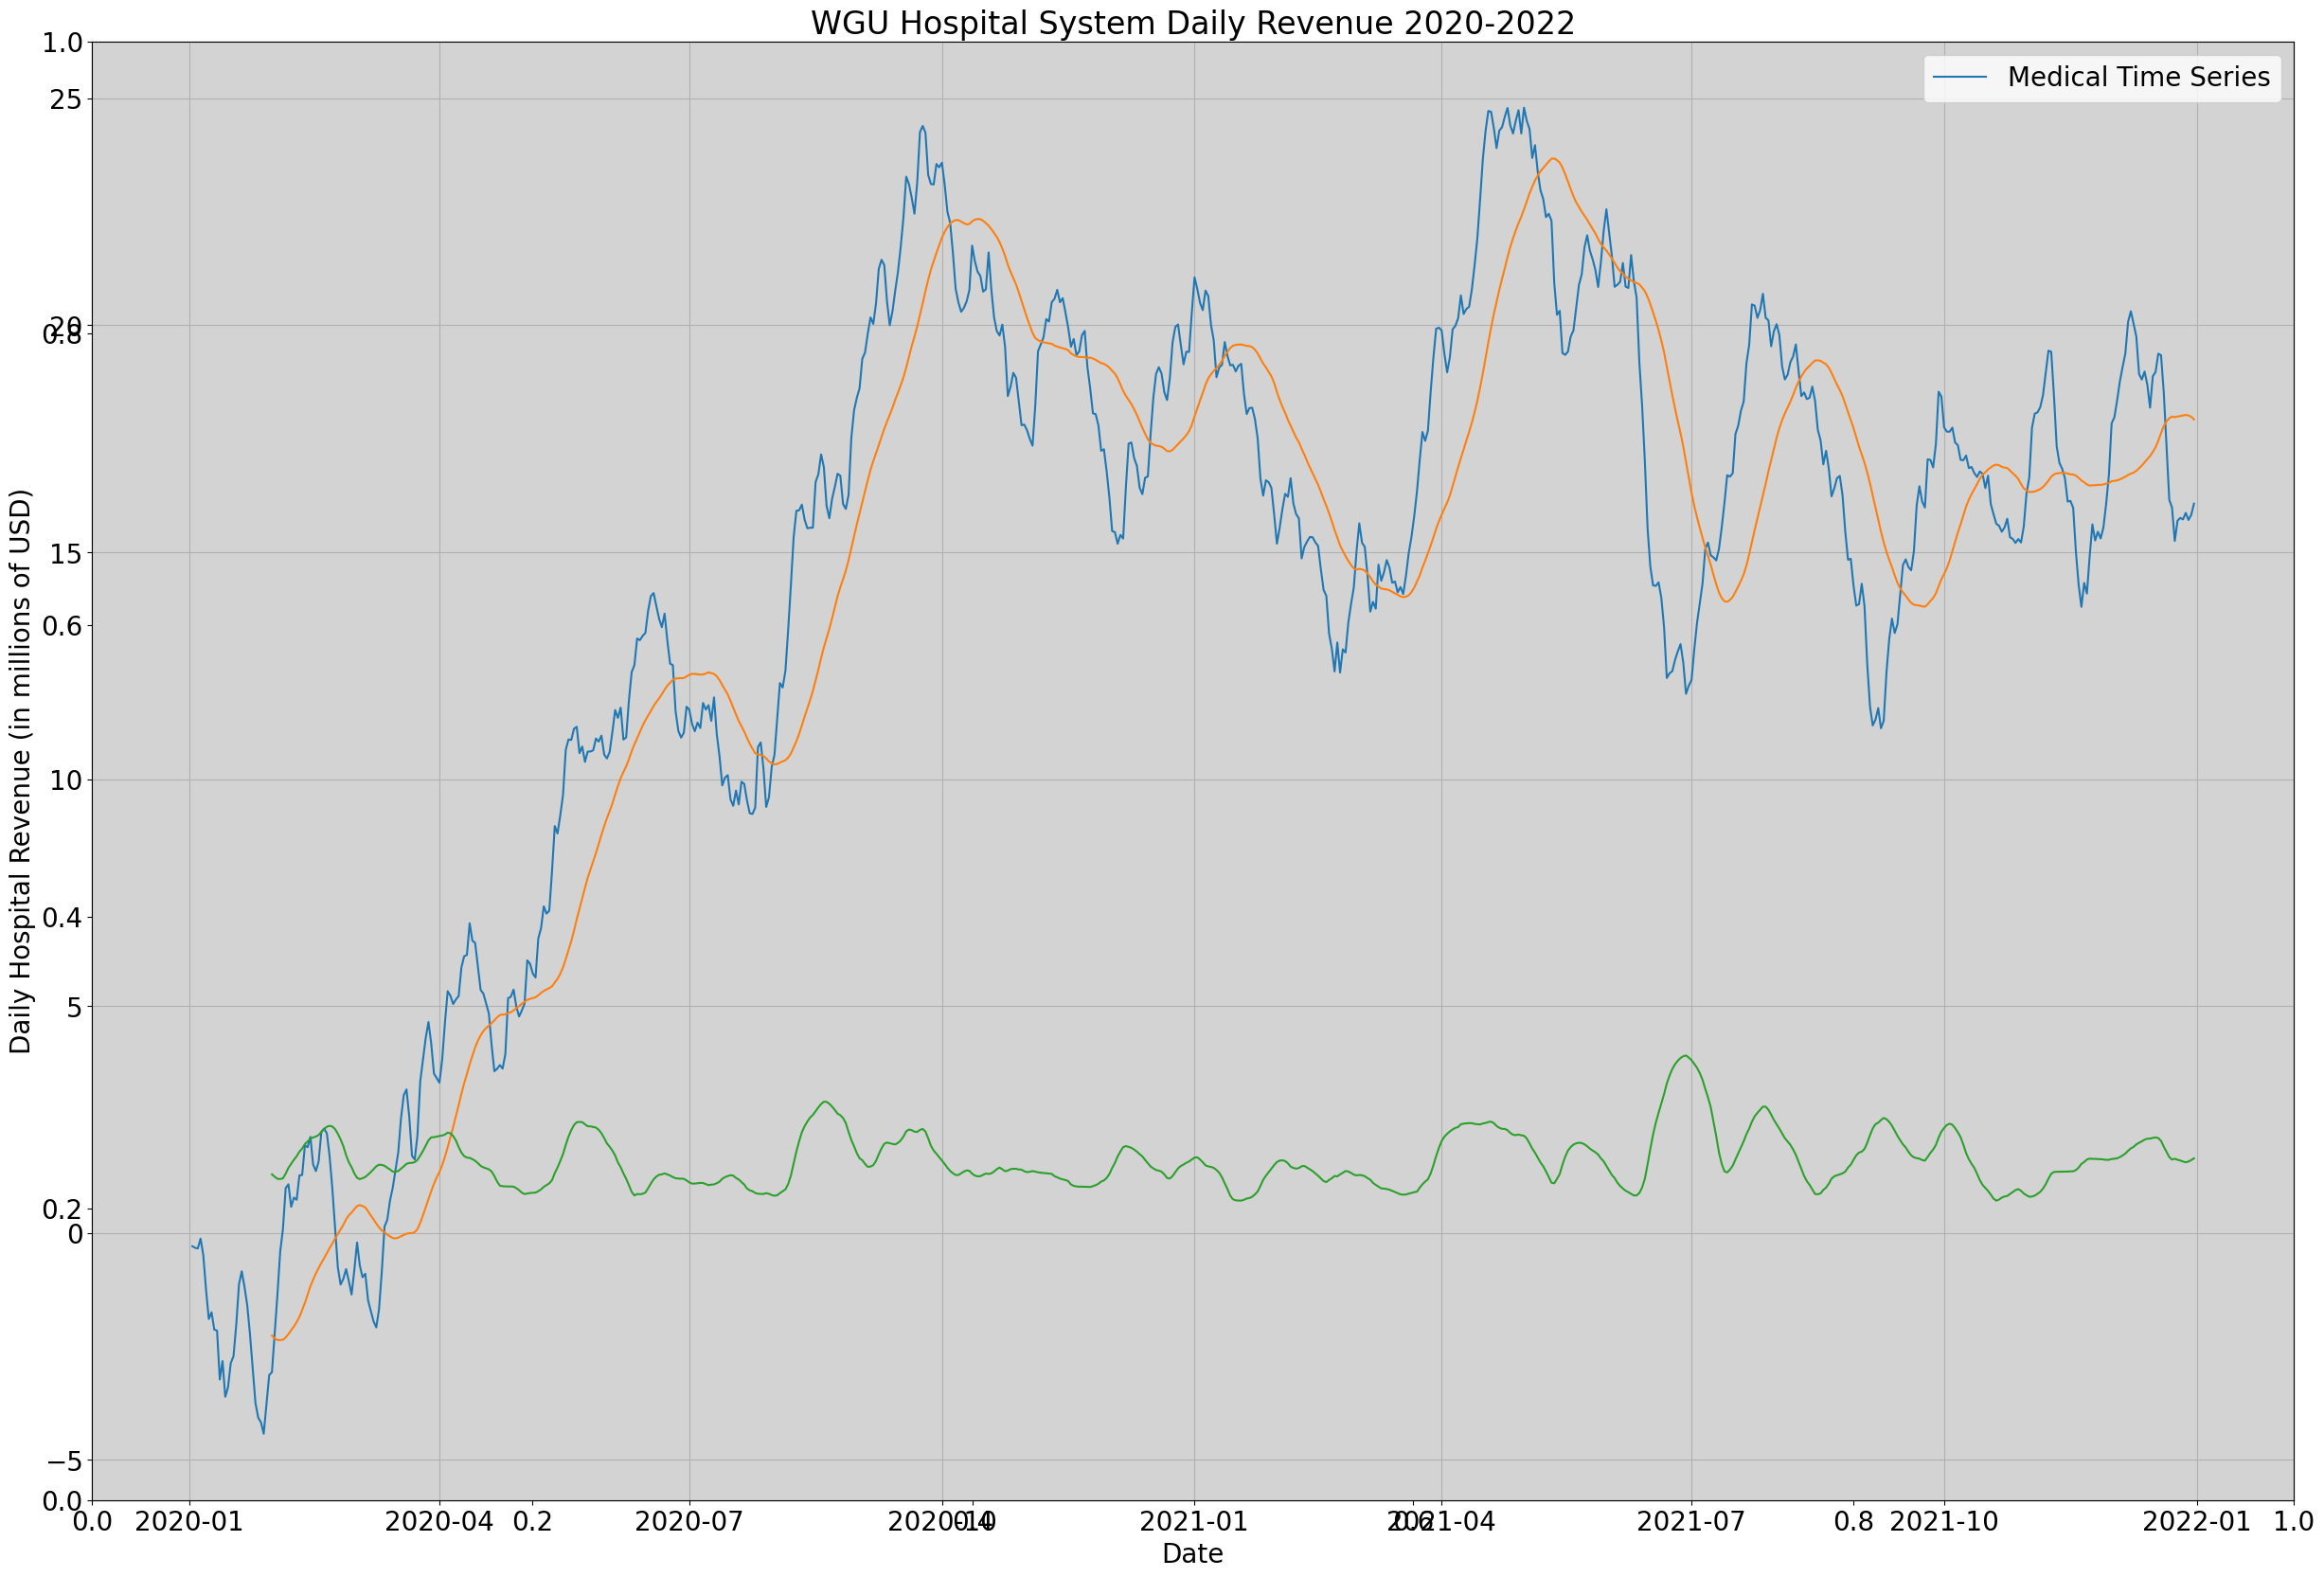

In [10]:
plt.figure(figsize=[30,20])

plt.rcParams.update({'font.size': 20})

# Add labels to the graph 
plt.title("WGU Hospital System Daily Revenue 2020-2022")
plt.xlabel("Date")
plt.ylabel("Daily Hospital Revenue (in millions of USD)")
ax = plt.axes()

ax.set_facecolor('lightgrey')
# Plot the time series data.
plt.plot(med_time_series_df)

# Create the trendline for the data. 
# Convert datetime objects to Matplotlib dates. 
# (matplotlib.dates — Matplotlib 3.8.2 Documentation, n.d.)

x = mdt.date2num(med_time_series_df.index)
y = med_time_series_df.Revenue
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.legend(['Medical Time Series'])
plt.grid()

# Show the plot.
plt.show() 

Plot the rolling mean and the standard deviation. 

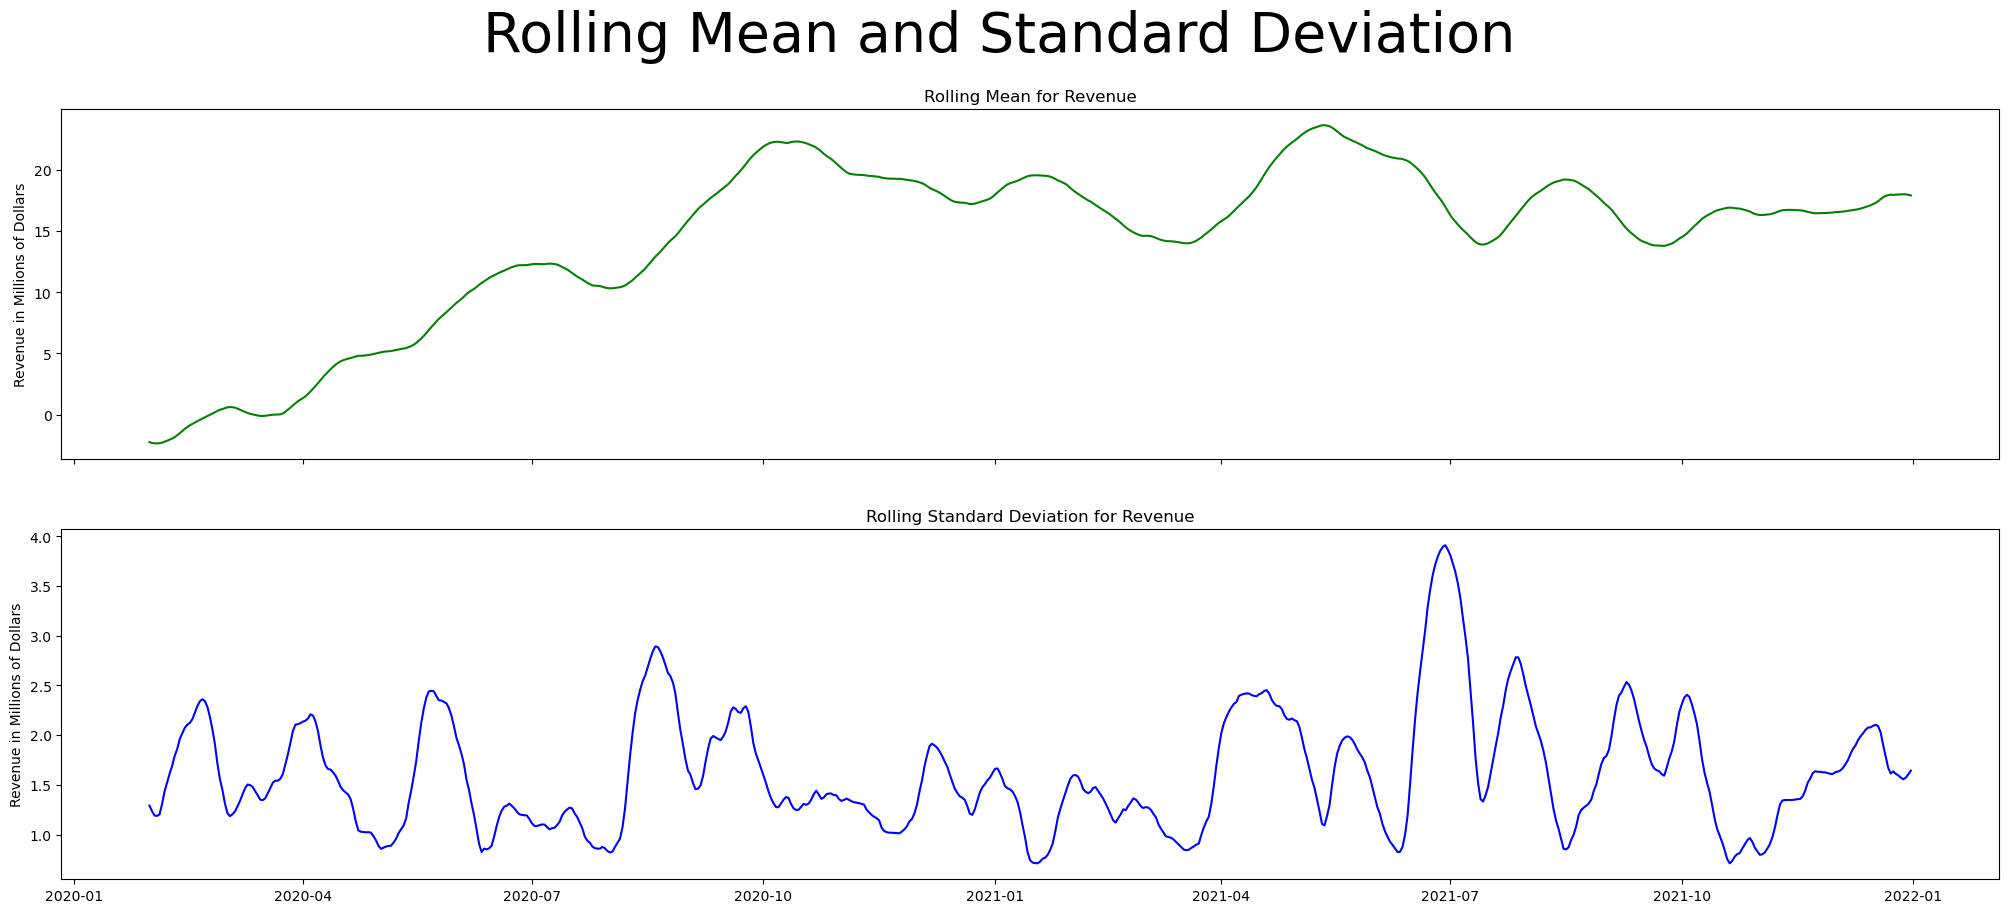

In [11]:
# Reset the plot parameters to show the plot properly.
plt.rcdefaults()

x = pd.Series(med_time_series_df.index.values)
x2 = pd.Series(range(med_time_series_df.shape[0]))


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(25 ,10), sharex=True, sharey=False)
fig.suptitle('Rolling Mean and Standard Deviation', fontsize=40)

ax1.set_title("Rolling Mean for Revenue")
ax1.set_ylabel('Revenue in Millions of Dollars' )

ax2.set_title("Rolling Standard Deviation for Revenue")
ax2.set_ylabel('Revenue in Millions of Dollars' )

ax1.plot(x, med_time_series_df['rolling_mean'], color='green')
ax2.plot(x, med_time_series_df['rolling_std'], color='blue')

## C2.Description of Time Step Formatting

Reviewing the graph there is a trend in the amount of revenue that the hospital experienced. In the last approximately five months (7-2021 to 1-2022) of the data set the revenue in this timeframe seems to hover around $15 million.  The trend during this period does not trend in the same manner as the previous months.  **More information can be found in the accompanying Word document.**

## C3. Evaluation of Stationarity

To proceed with time series analysis we need to examine the data set for stationarity.  We need data that does not exhibit trends or seasonality.  If the dataset exhibits these trends then we must render the data in a matter so the data does not exhibit this phenomena. The code below clearly shows that the data is non-stationary.

In [12]:
# Call the function to calculate Dickey-Fuller and output the results.
results = calc_dickey_fuller(med_time_series_df['Revenue'].values)

Check to see if the data is stationary by looking at the critical value relative to the p-value.  The critical value will be 0.05.

In [13]:
# Print the results.
print_results_tuple(results)


ADF Statistic: 	 -2.210771
p-value: 	 0.202360
Critical Values: 

	1%: -3.439
	5%: -2.866
	10%: -2.569


In [14]:
# Test for the critical value
test_stationarity(results[1])



Accept the null hypothesis, the data is non-stationary. 


Based on the results of the previous calculation the data is **not** stationary. We will need to employ a method to create a stationary data set.  This method will employ the **diff()** function. It will be prudent to drop the row that had no data associated with it.  This was the first day the observations started being recorded. 

In [15]:
# Apply differencing to the data.

med_stationary_df = med_time_series_df.diff(periods=1, axis=0).dropna()

In [16]:
med_stationary_df.info()
med_stationary_df.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 700 entries, 2020-02-01 to 2021-12-31
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Revenue       700 non-null    float64
 1   rolling_mean  700 non-null    float64
 2   rolling_std   700 non-null    float64
dtypes: float64(3)
memory usage: 21.9 KB


(700, 3)

In [17]:
results = calc_dickey_fuller(med_stationary_df['Revenue'].values)

In [18]:
# Print the results.
print_results_tuple(results)


ADF Statistic: 	 -17.001456
p-value: 	 0.000000
Critical Values: 

	1%: -3.440
	5%: -2.866
	10%: -2.569


In [19]:
# Test for the critical value
test_stationarity(results[1])


Reject the null hypothesis H0, the data is stationary.


### Plot the transformed data.

To visualize the data for later discussion in subsequent sections of the assessment.

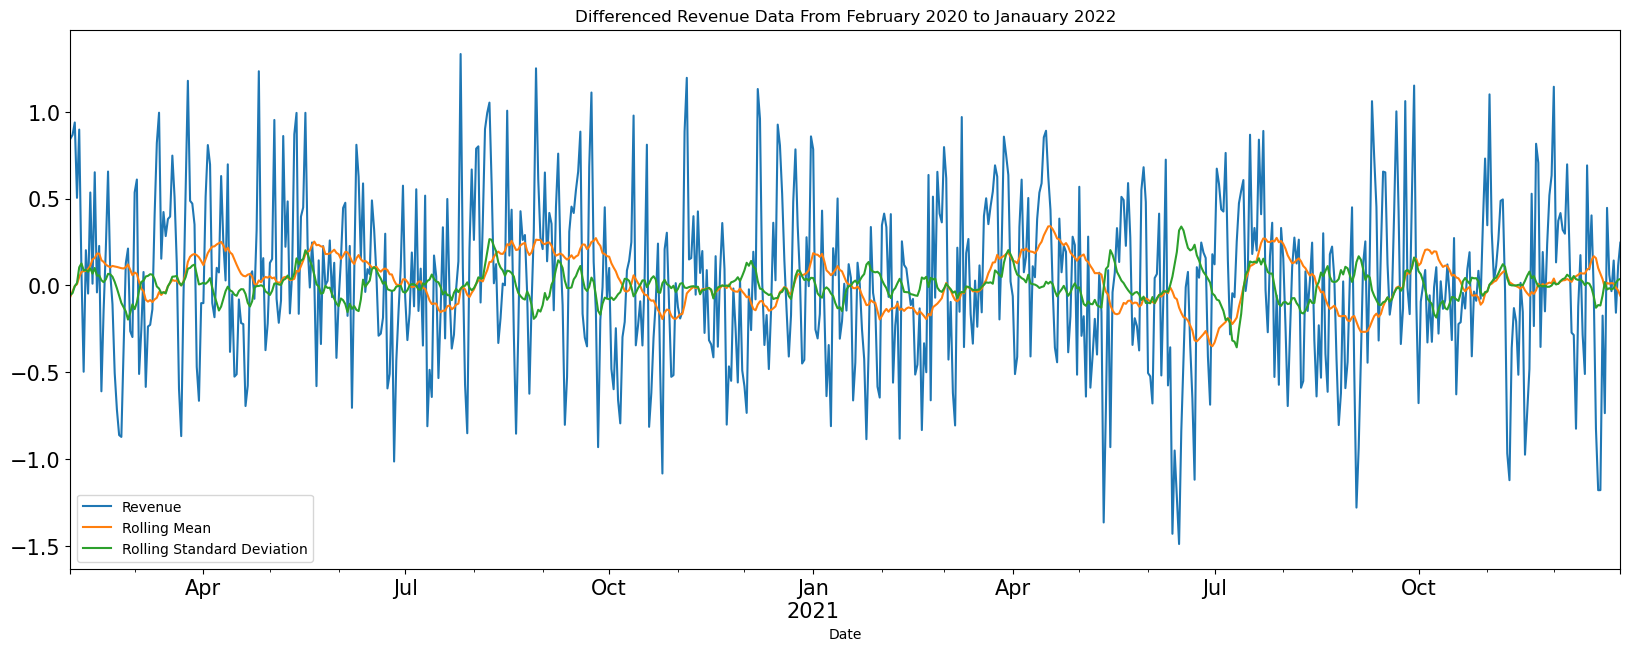

In [20]:
# Plot the transformed data.
med_stationary_df['Revenue'].plot(figsize=[20,7], fontsize=15
                                  ,  title="Differenced  Revenue Data")
med_stationary_df['rolling_mean'].plot(figsize=[20,7]
                                       ,title="Differenced Revenue Data From February 2020 to Janauary 2022")

med_stationary_df['rolling_std'].plot(figsize=[20,7]
                                       ,title="Differenced Revenue Data From February 2020 to Janauary 2022")

plt.legend(['Revenue','Rolling Mean', 'Rolling Standard Deviation'])

In [ ]:
## C4. Steps Used to Clean the Data

The steps that were undertaken can be found in the accompanying Word document.

## C4. Steps Used to Clean the Data

The steps that were undertaken can be found in the accompanying Word document. 

## C5. Copy of the Cleaned Data

Copy of the cleaned data can be found in this file:

- **Heino D213 Task Stationary.csv**

The data that will be exported to the CSV file is the stationary data.  The reason for this is that this data is now in a state that can be used for time series analysis.  

The training and test data will be saved to files in the following section D1.  It was more logical to accompanish the training task in this later section.

# Part IV: Model Identification and Analysis

In this section there will be a discussion of the following:
- Any presence of a seasonal component.
- Identification of trends within the data.
- Review the autocorrelation function.
- Create the spectral density graphs.
- Create the decomposed time series graphs.

There will be an identification and discussion of an autoregressive integrated moving average (ARIMA). A forecasting will be attempted using the model that has been created.  Any calculation will also be discussed and presented in this section.

## D1. Findings and Analysis

Tasks:

1. Training and test set for the model.
2. Check for seasonality.
3. Check for trends.
4. Look at the autocorrealtion function.
5. Look at Spectral density.
6. Look at the decomposed time series data.
7. Lack of Trends in the residuals of the decomposed time series data.

### 1. The training and test set for the model.

The stationary data has been split into 80% training and 20% testing sets. Shuffle parameter has been set to False to keep the data series intact.

**Note:** Both the test_size and train_size have been set.  This is more for future reference and only one of these parameters really needs to be set.

In [21]:
# Create the train and test set.
# Do not shuffle to keep the series intact.
train, test = train_test_split(med_stationary_df, test_size=0.2, train_size=.80
                               , shuffle=False, random_state=247)

In [22]:
test.info()
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2021-08-14 to 2021-12-31
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Revenue       140 non-null    float64
 1   rolling_mean  140 non-null    float64
 2   rolling_std   140 non-null    float64
dtypes: float64(3)
memory usage: 4.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 560 entries, 2020-02-01 to 2021-08-13
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Revenue       560 non-null    float64
 1   rolling_mean  560 non-null    float64
 2   rolling_std   560 non-null    float64
dtypes: float64(3)
memory usage: 17.5 KB


In [23]:
# Output the train and test data to CSV files.
#train.to_csv('Heino D213 Task1 Train.csv')

#test.to_csv('Heino D213 Task1 Test.csv')

Copy of the test and trainig data can be found in these files:

- **Heino D213 Task1 Train.csv**
- **Heino D213 Task1 Test.csv**

The data that will be exported to the CSV file is the testand train data.

### 2. Check for seasonality.

In this section, there will be a check for the seasonality of the data. This will be accomplished by looking at a visualization of the differenced data.  This part of the analysis will make use of the **seasonal_decompose** method that is found in the **statsmodels.tsa.seasonal**.


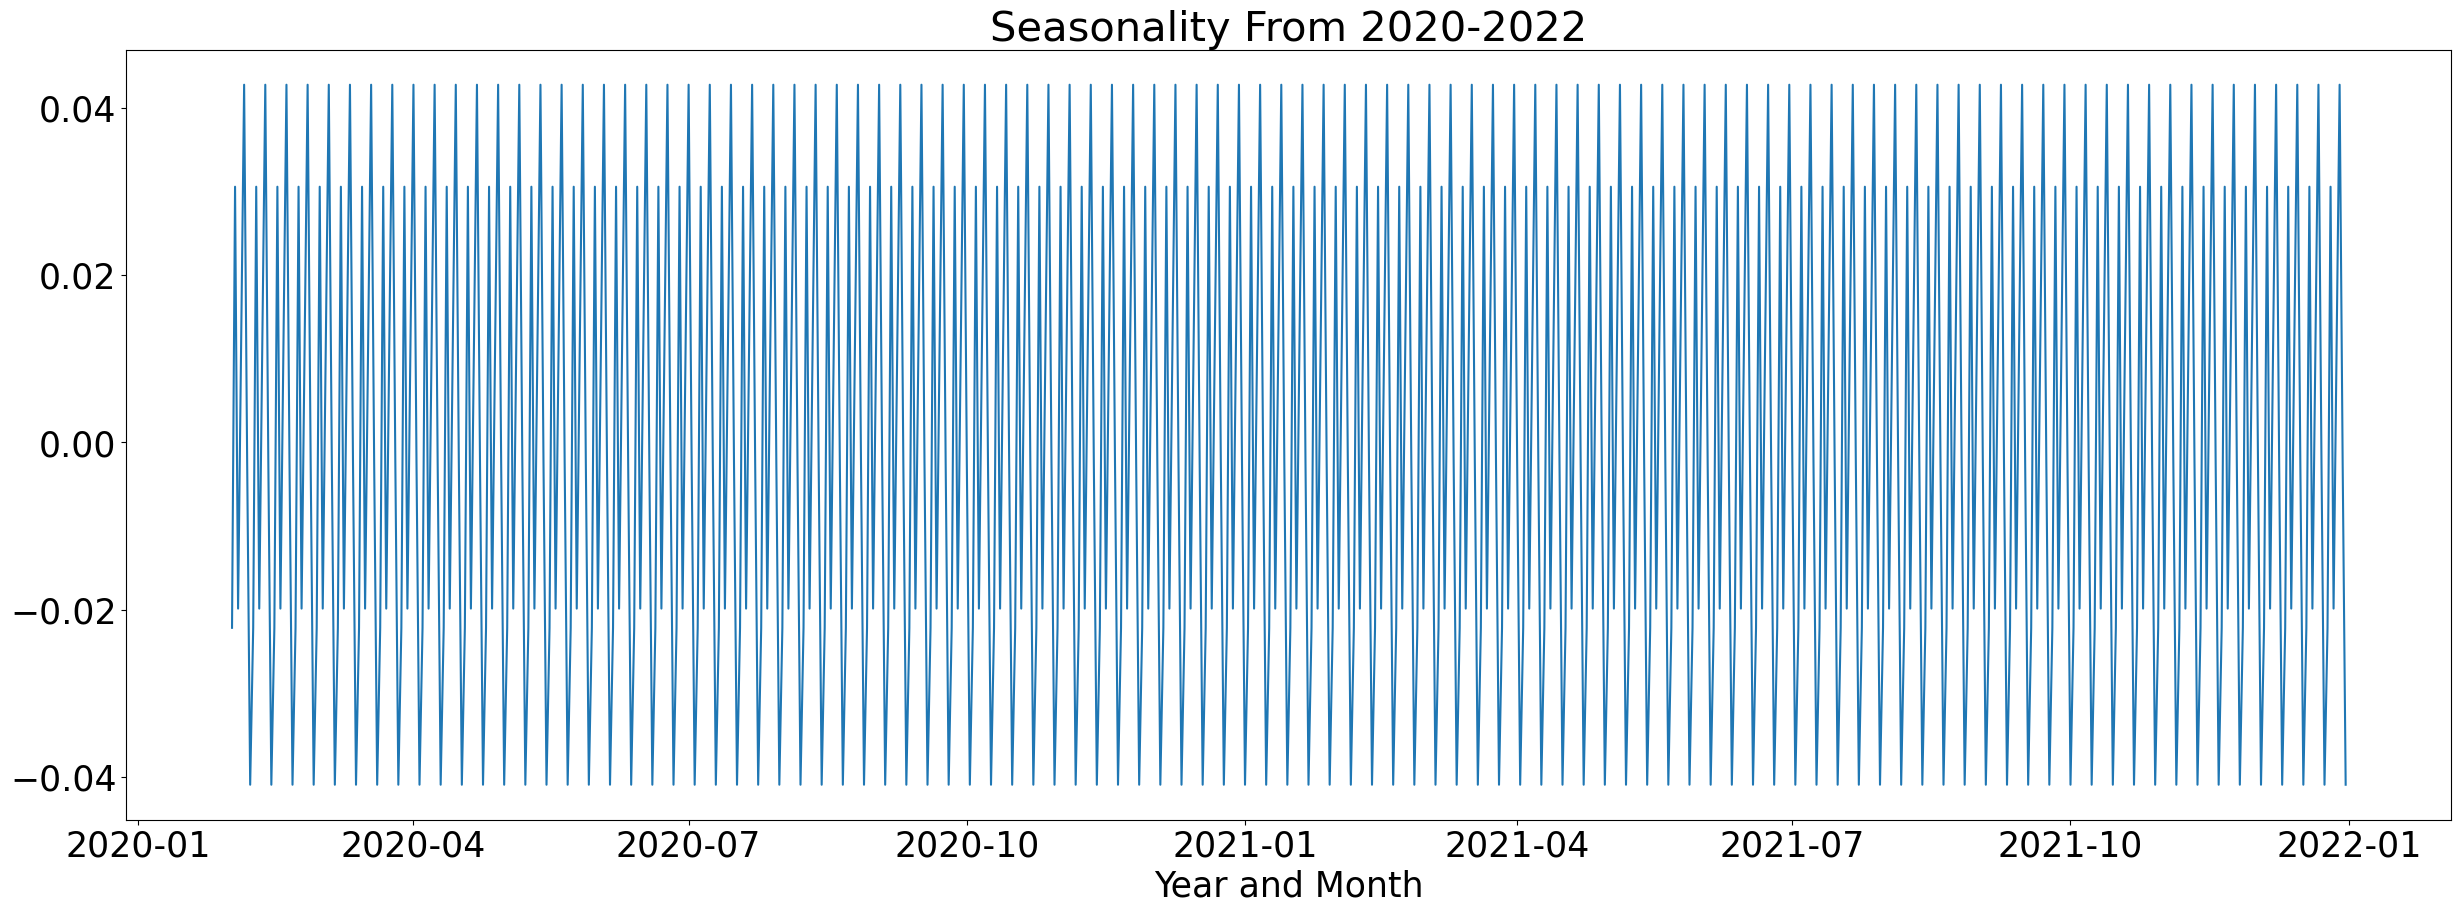

In [24]:
seasonal_decomp = seasonal_decompose(med_stationary_df['Revenue'])

#Plot the data.

# Show a graph of the seasonal decomposed data. 
plt.figure(figsize=[30, 10])
plt.rcParams.update({'font.size': 25})
plt.xlabel("Year and Month")
plt.title("Seasonality From 2020-2022")

# Plot the seasonal component of the data.
plt.plot(seasonal_decomp.seasonal)

Reviewing the graph above we can see that there is a very marginal degree of seasonality.  This is indicated by the very small value of +0.04 or -0.06.  There is a need to look at this data in closer detail by looking at a small section of the data. This is also to look to see if there is any noise in the graph that may be affecting the seasonality of the data.  The next graph will look at a small chunk of the data.  Looking from January 1, 2020 to February 1, 2020.

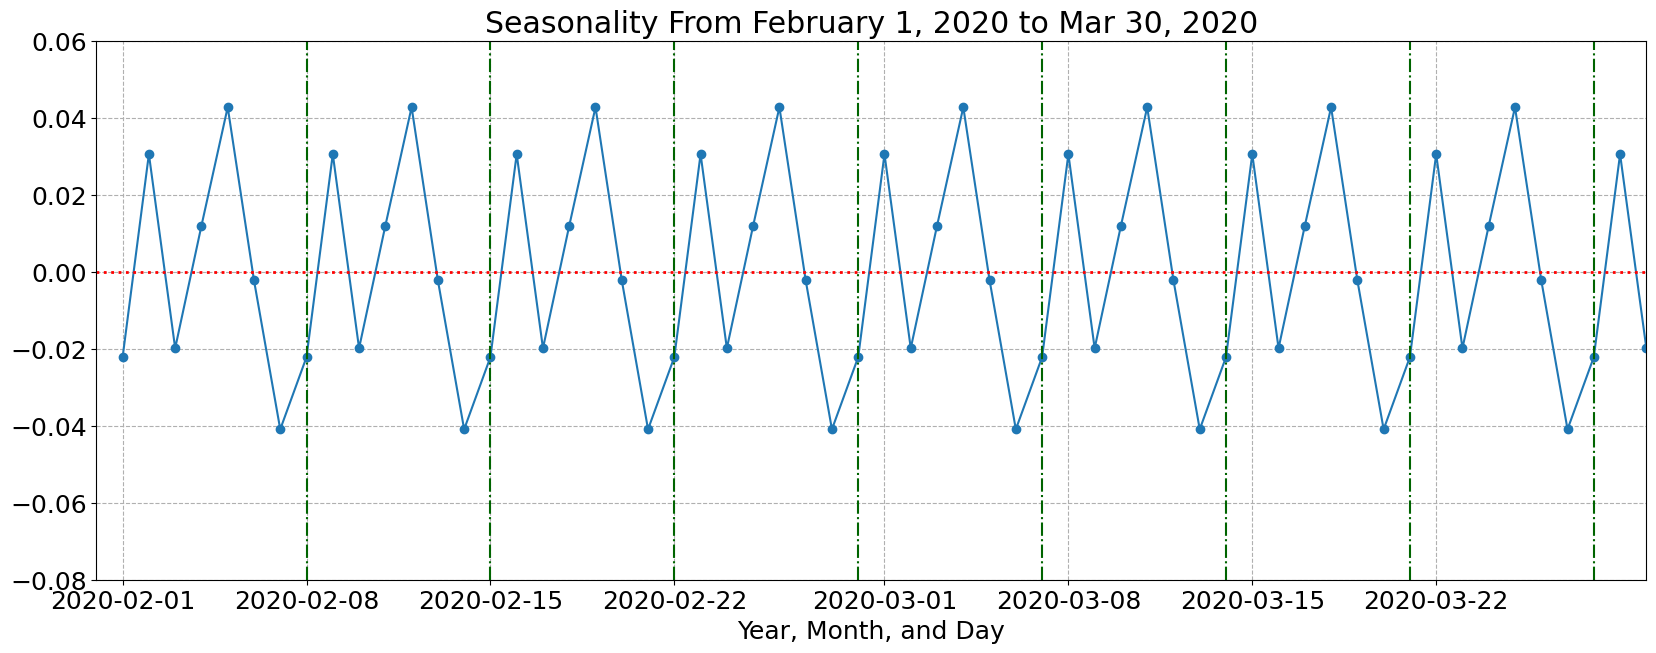

In [25]:
plt.figure(figsize=[20, 7])
plt.rcParams.update({'font.size': 18})

plt.xlabel("Year, Month, and Day")
plt.title("Seasonality From February 1, 2020 to Mar 30, 2020")
plt.ylim(-0.08, 0.06)
plt.xlim(pd.to_datetime('2020-01-31'), pd.to_datetime('2020-03-30'))
plt.grid(linestyle='--')

plt.plot(seasonal_decomp.seasonal, marker='o')

plt.axhline(y=0, linewidth=2, linestyle=':',color='r')
plt.axvline(x=pd.to_datetime('2020-02-08'), color='darkgreen', linestyle='dashdot')
plt.axvline(x=pd.to_datetime('2020-02-15'), color='darkgreen', linestyle='dashdot')
plt.axvline(x=pd.to_datetime('2020-02-22'), color='darkgreen', linestyle='dashdot')
plt.axvline(x=pd.to_datetime('2020-02-29'), color='darkgreen', linestyle='dashdot')
plt.axvline(x=pd.to_datetime('2020-03-07'), color='darkgreen', linestyle='dashdot')
plt.axvline(x=pd.to_datetime('2020-03-14'), color='darkgreen', linestyle='dashdot')
plt.axvline(x=pd.to_datetime('2020-03-21'), color='darkgreen', linestyle='dashdot')
plt.axvline(x=pd.to_datetime('2020-03-28'), color='darkgreen', linestyle='dashdot')


Looking at the smaller interval it is apparent that the data even after differencing still shows some seasonality. This is evident by the same pattern showing up throughout the time interval. This can be inferred by looking at the data cycles between the green vertical lines.  This would happen if you take the same amount of days.  In the case of this graph, it was seven days.  However, the value that was discussed previously is very small and should have little to no effect on the modeling process going forward. 

### 3. Check for trends.

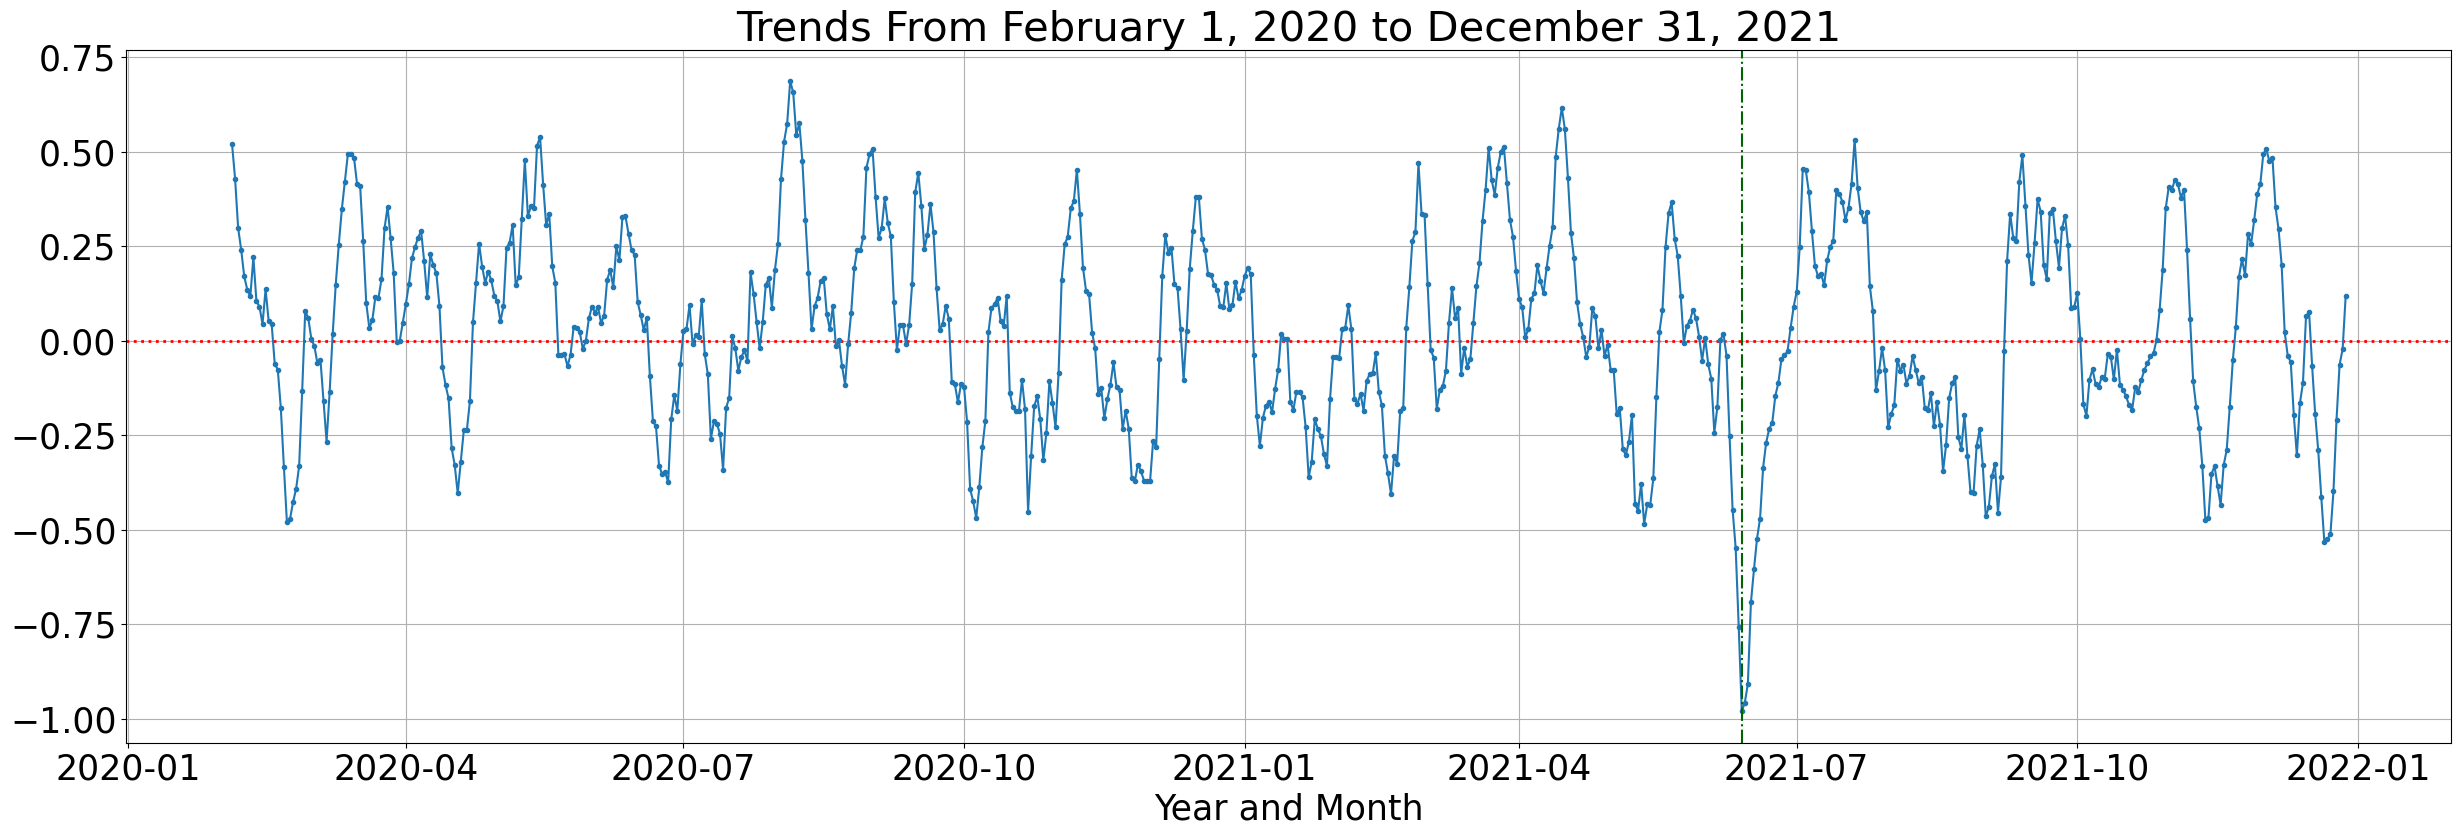

In [26]:
plt.rcParams.update({'font.size': 25})

plt.figure(figsize=[30, 9])
plt.xlabel("Year and Month")
plt.title("Trends From February 1, 2020 to December 31, 2021")

plt.axhline(y=0, linewidth=2, linestyle=':',color='r')
plt.plot(seasonal_decomp.trend, marker='.')
plt.axvline(x=pd.to_datetime('2021-06-13'), color='darkgreen'
            , linestyle='dashdot')
plt.grid()


Based on the graph above, there does not seem to be any discernible pattern in the dataset. There is a noticeable drop in revenue around June 13th of 2021 (see green vertical line).This dip may be considered an outlier in the dataset. As it seems to be well outside of the range of the other revenue values.

### 4. The Autocorrelation Function.

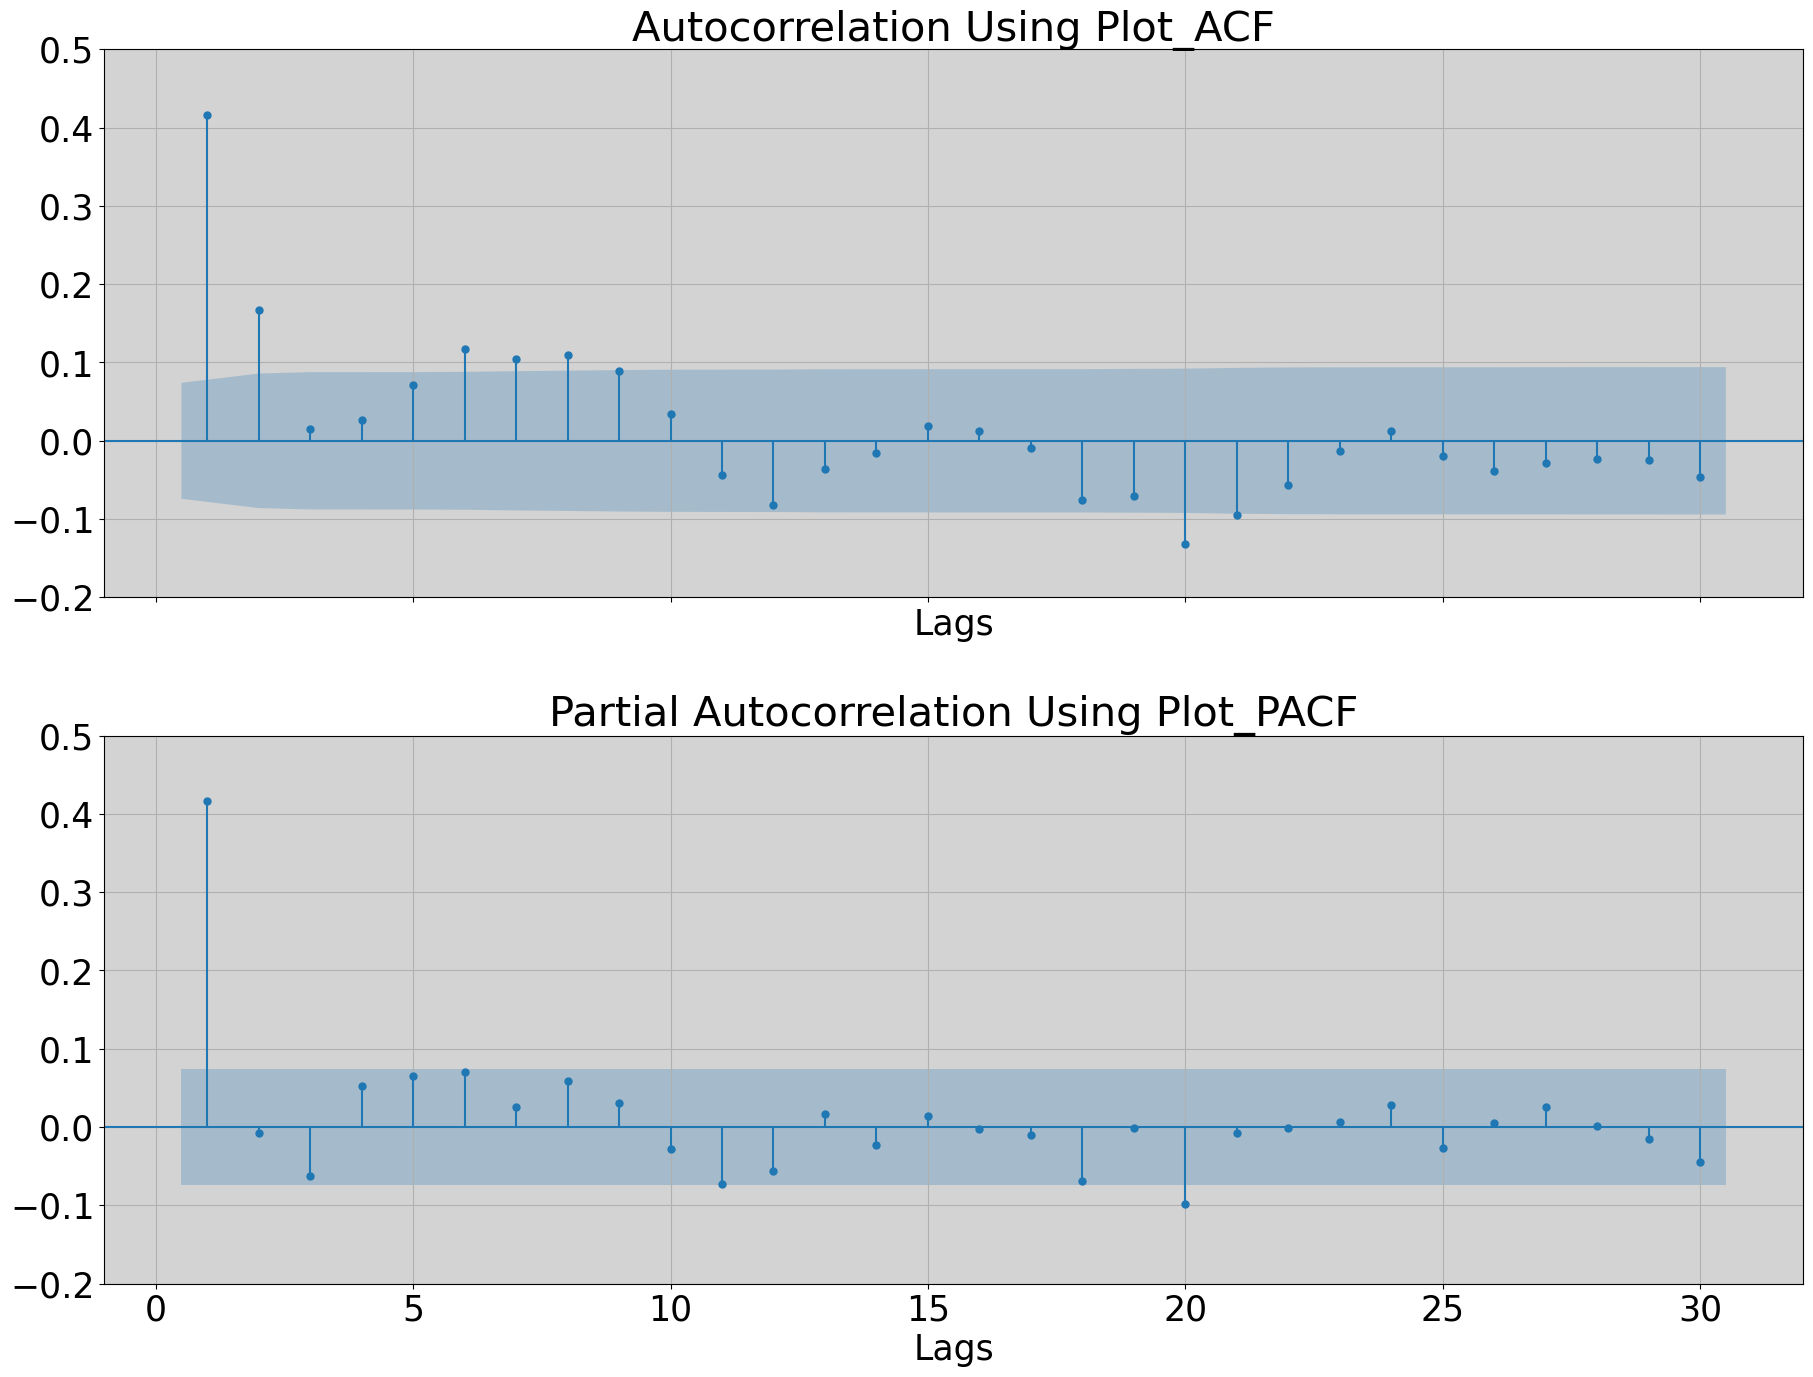

In [27]:
# Plot the auto correlation

lag = 30

fig, (ax,ax2) = plt.subplots(2,1, figsize=[20,15], sharex=True)
fig.tight_layout(pad=3.0)


# Plot the ACF graph.
plot_acf(med_stationary_df['Revenue'], lags=lag, zero=False
         , title="Autocorrelation Using Plot_ACF", ax=ax)
ax.set_ylim((-.20, 0.50))
ax.set_xlabel("Lags")
ax.set_facecolor("lightGray")
ax.grid()

#Plot the PACF graph.
plot_pacf(med_stationary_df['Revenue'], lags=lag, zero=False
         , title="Partial Autocorrelation Using Plot_PACF", ax=ax2)
ax2.set_xlabel("Lags")
ax2.set_facecolor("lightGray")
ax2.set_ylim((-.20, 0.50))
ax2.grid()


Plot both ACF and PACF for comparison of the values.  Plotted together to make it easier to show the values change in respect to each other

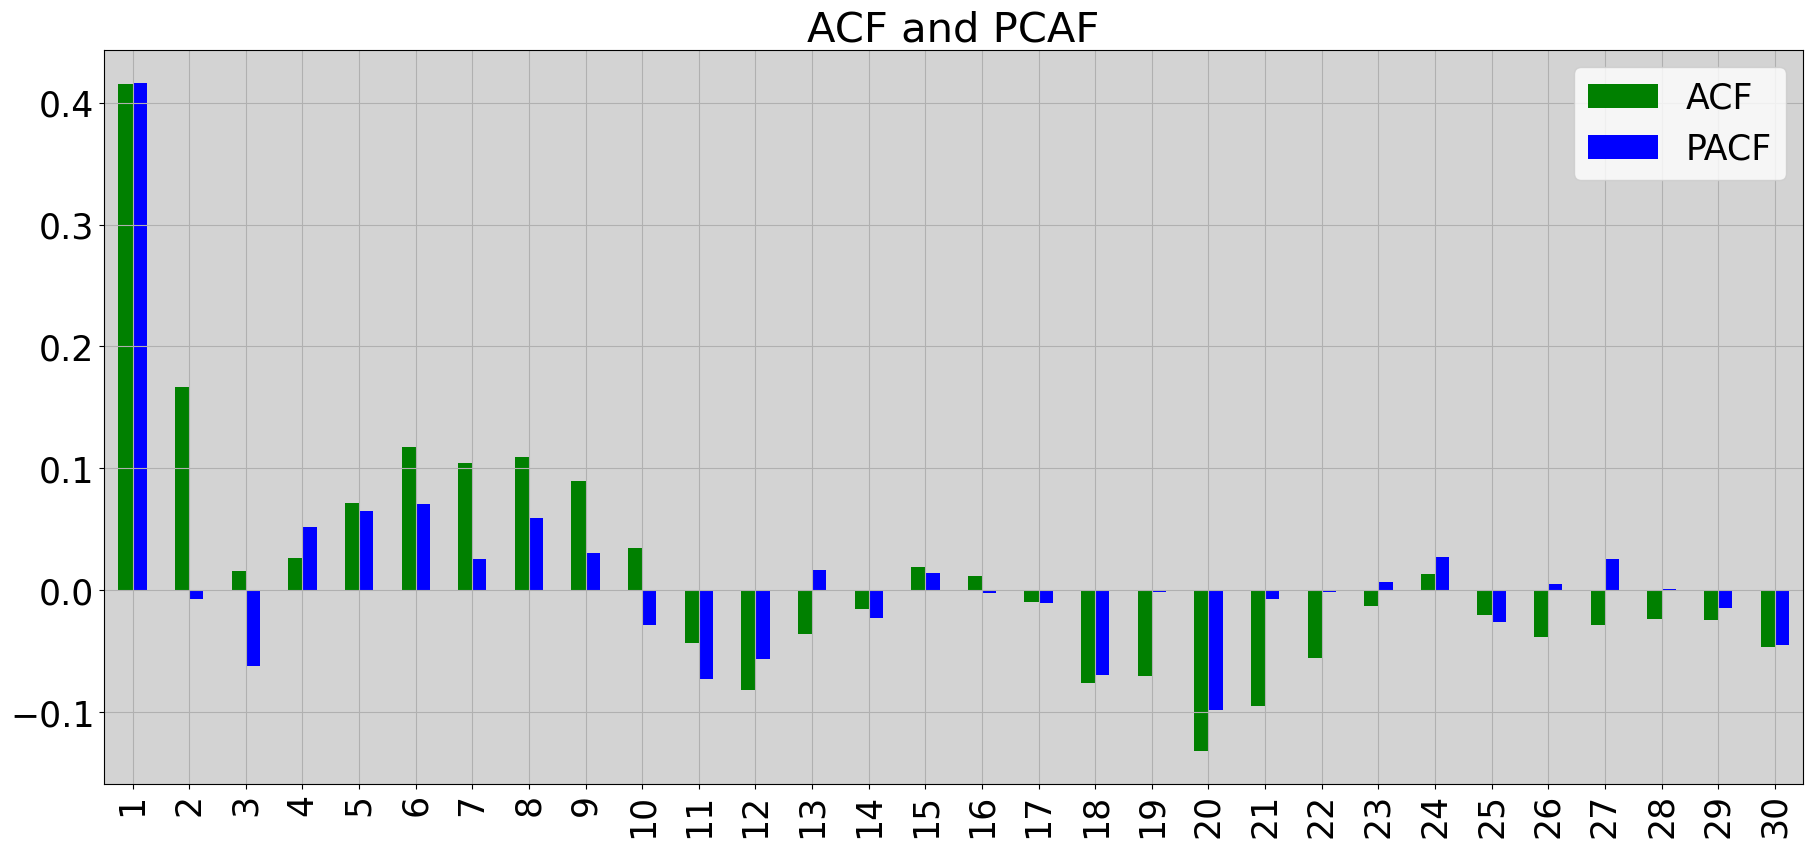

In [28]:
# Plot both on the same graph for comparison.#################################
# (statsmodels.tsa.stattools.pacf - Statsmodels 0.15.0 (+200), n.d.)
# (statsmodels.tsa.stattools.acf - Statsmodels 0.14.1, n.d.)

revenue_acf_df = acf(med_stationary_df['Revenue'], nlags=lag, missing='drop')

# Will use the default Yule-Walker. 
revenue_pacf_df = pacf(med_stationary_df['Revenue'], nlags=lag) 

# Create a pandas dataframe to hold the data from the correlation.
acf_pacf_df = pd.DataFrame([revenue_acf_df, revenue_pacf_df]).T

# Set the columns
acf_pacf_df.columns = ['ACF','PACF']
acf_pacf_df.drop(index=0, inplace=True)

fig, ax = plt.subplots(1,1, figsize=[20, 10], sharex=True)
fig.tight_layout(pad=3.0)

ax = acf_pacf_df.plot(kind='bar', color=('green', 'blue')
                      , title="ACF and PCAF", ax=ax)
ax.set_facecolor("lightGray")
ax.grid()


### 5. Spectral density.  

Create a spectral density plot of the data.

<AxesSubplot:title={'center':'Stationary Data'}>

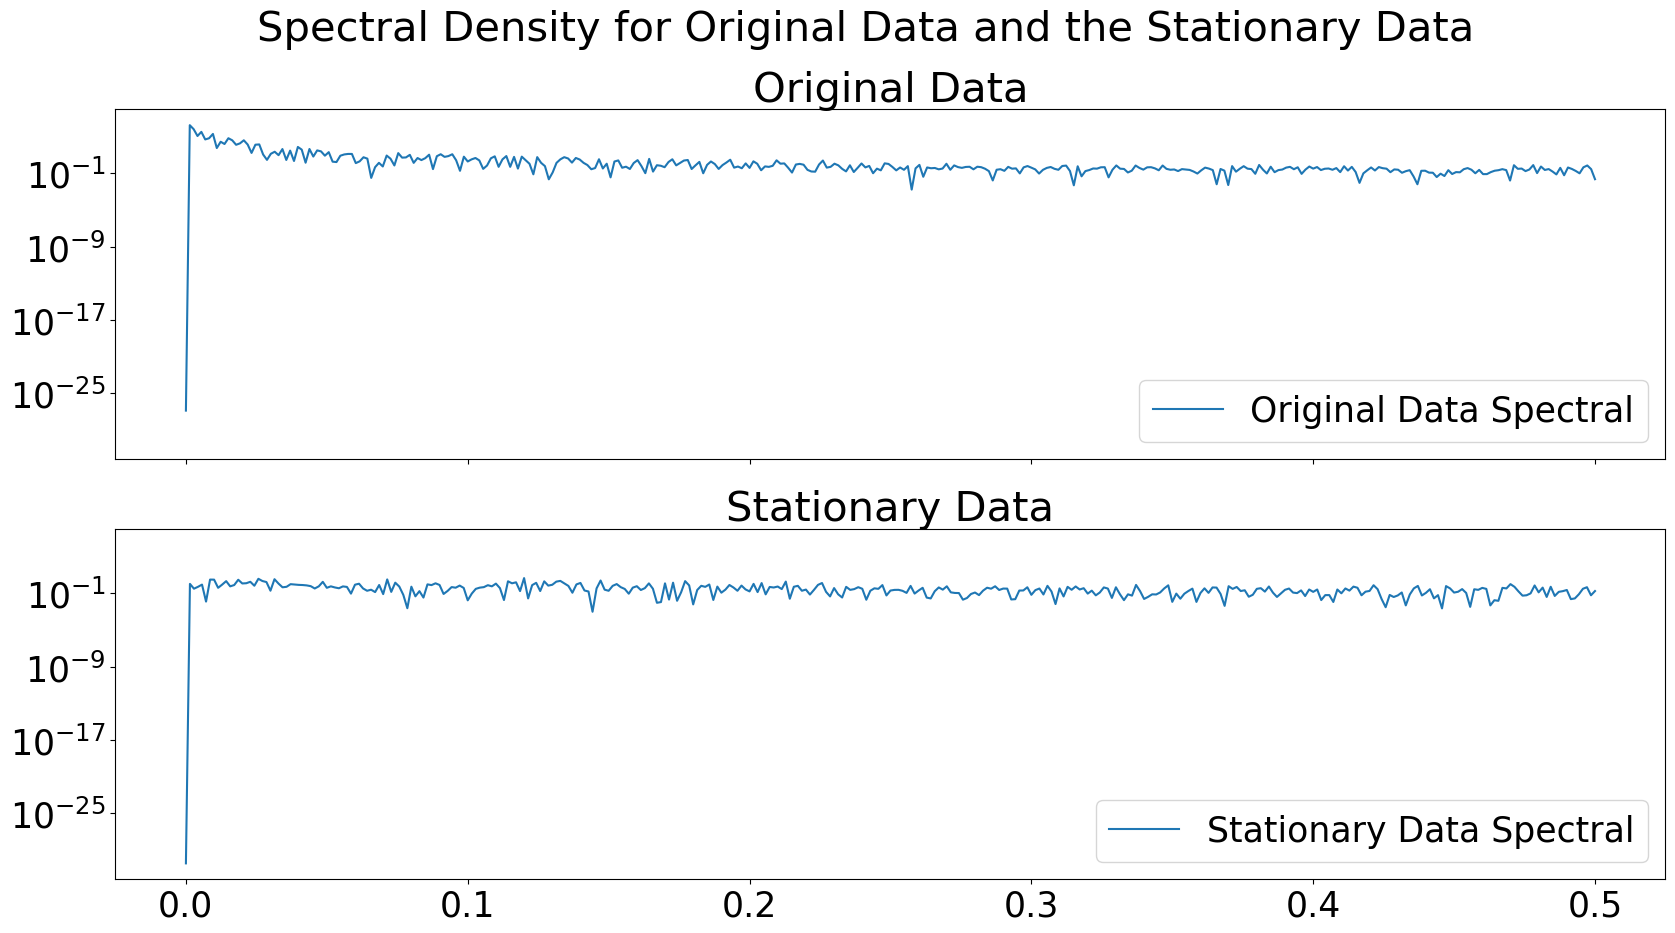

In [29]:
# Create a spectral density plot. Using a periodogram.
fig,ax = plt.subplots(2,1, figsize=(20,10), sharex=True, sharey=True)
fig.suptitle('Spectral Density for Original Data and the Stationary Data', fontsize=30)

# Create a plot for the first set of data the initial dataframe.
create_spectral_plt(dataframe=med_time_series_df,ax=ax, column='Revenue'
                    ,i=0, graph_title='Original Data'
                    , legend_text='Original Data Spectral')

create_spectral_plt(dataframe=med_stationary_df,ax=ax, column='Revenue'
                    ,i=1, graph_title='Stationary Data'
                    , legend_text='Stationary Data Spectral')


Plot using the PSD function available in the matplotlib.  This is done for mainly for comparison.

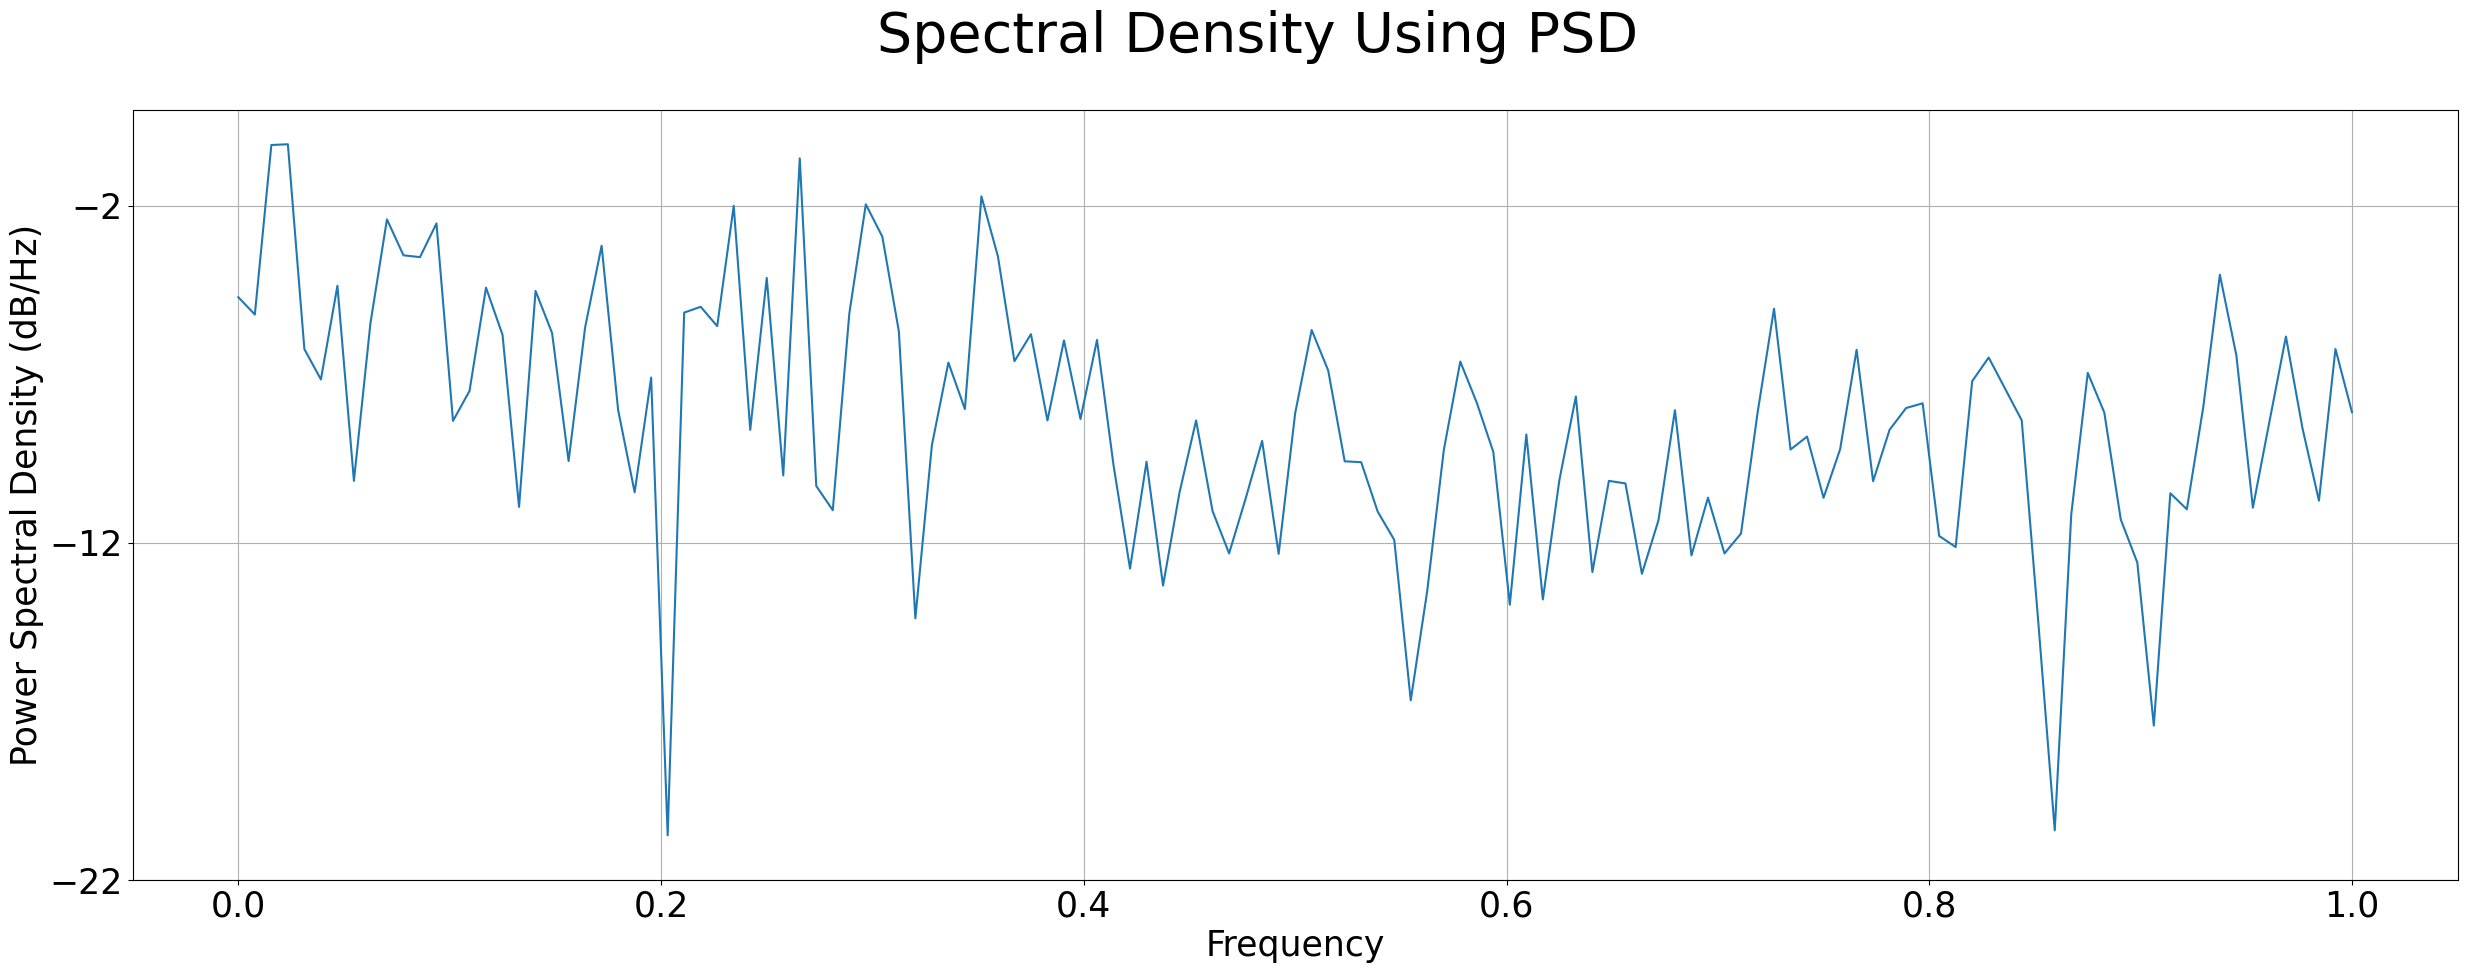

In [30]:
# Using the matplot version to view the spectral density graph of the 
# stationary data.
fig,ax = plt.subplots(1,1, figsize=(30,10))
fig.suptitle('Spectral Density Using PSD', fontsize=40)

psd = plt.psd(x=med_stationary_df.Revenue)

### 6. The Decomposed Time Series.

This section shows a visual of the decomposed data.  It makes use of the **plot()**.

Text(0.5, 1.0, 'The Decomposed Time Series')

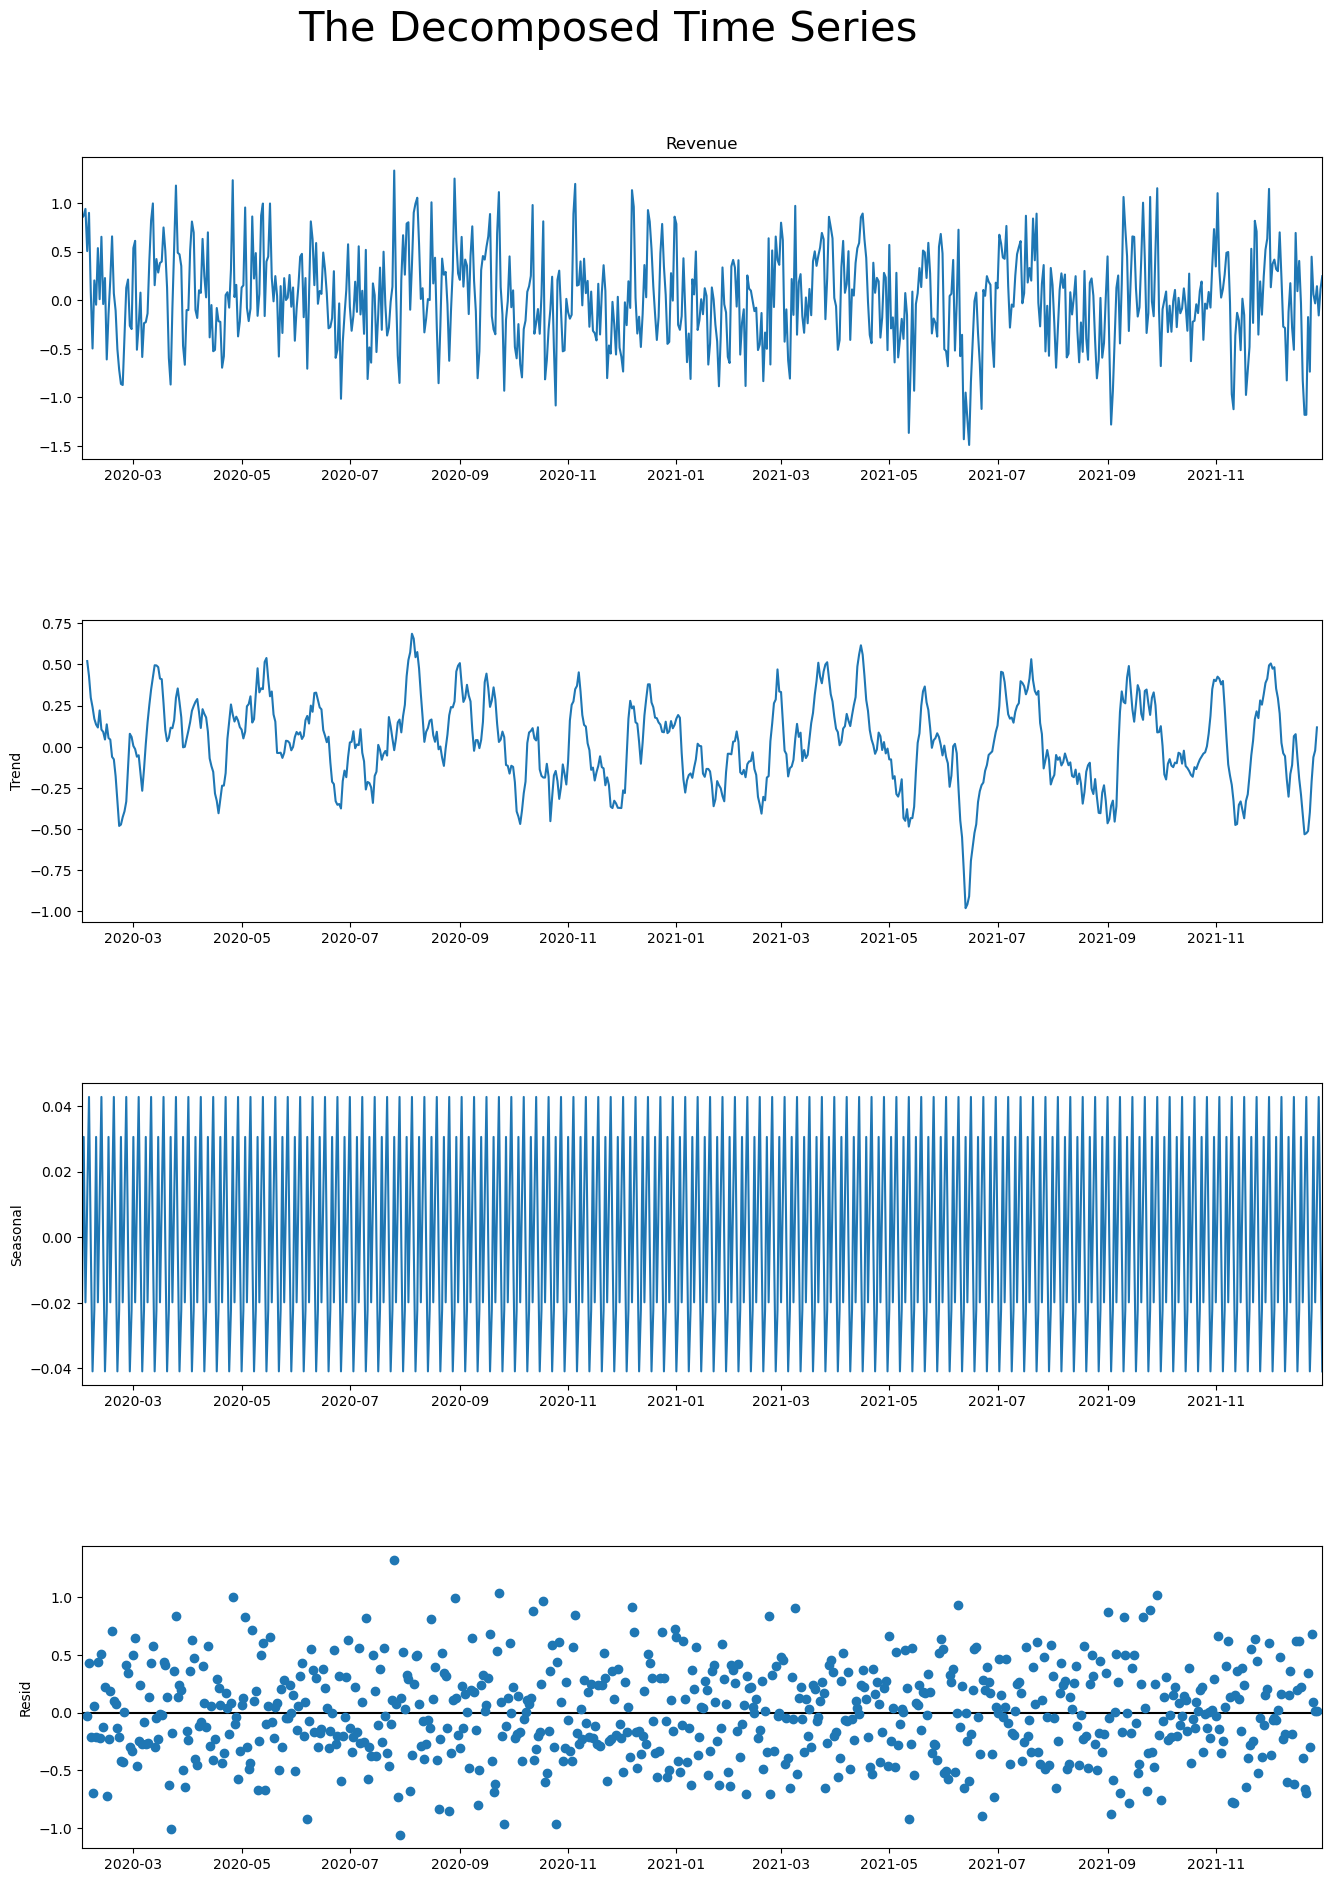

In [31]:
plt.rcdefaults()

newplot = seasonal_decomp.plot()
newplot.set_figwidth(15)
newplot.set_figheight(20) 
newplot.suptitle('The Decomposed Time Series', fontsize=30, y=1.0 )


### 7.  Lack of Trends in the Residuals of the Decomposed Time Series.

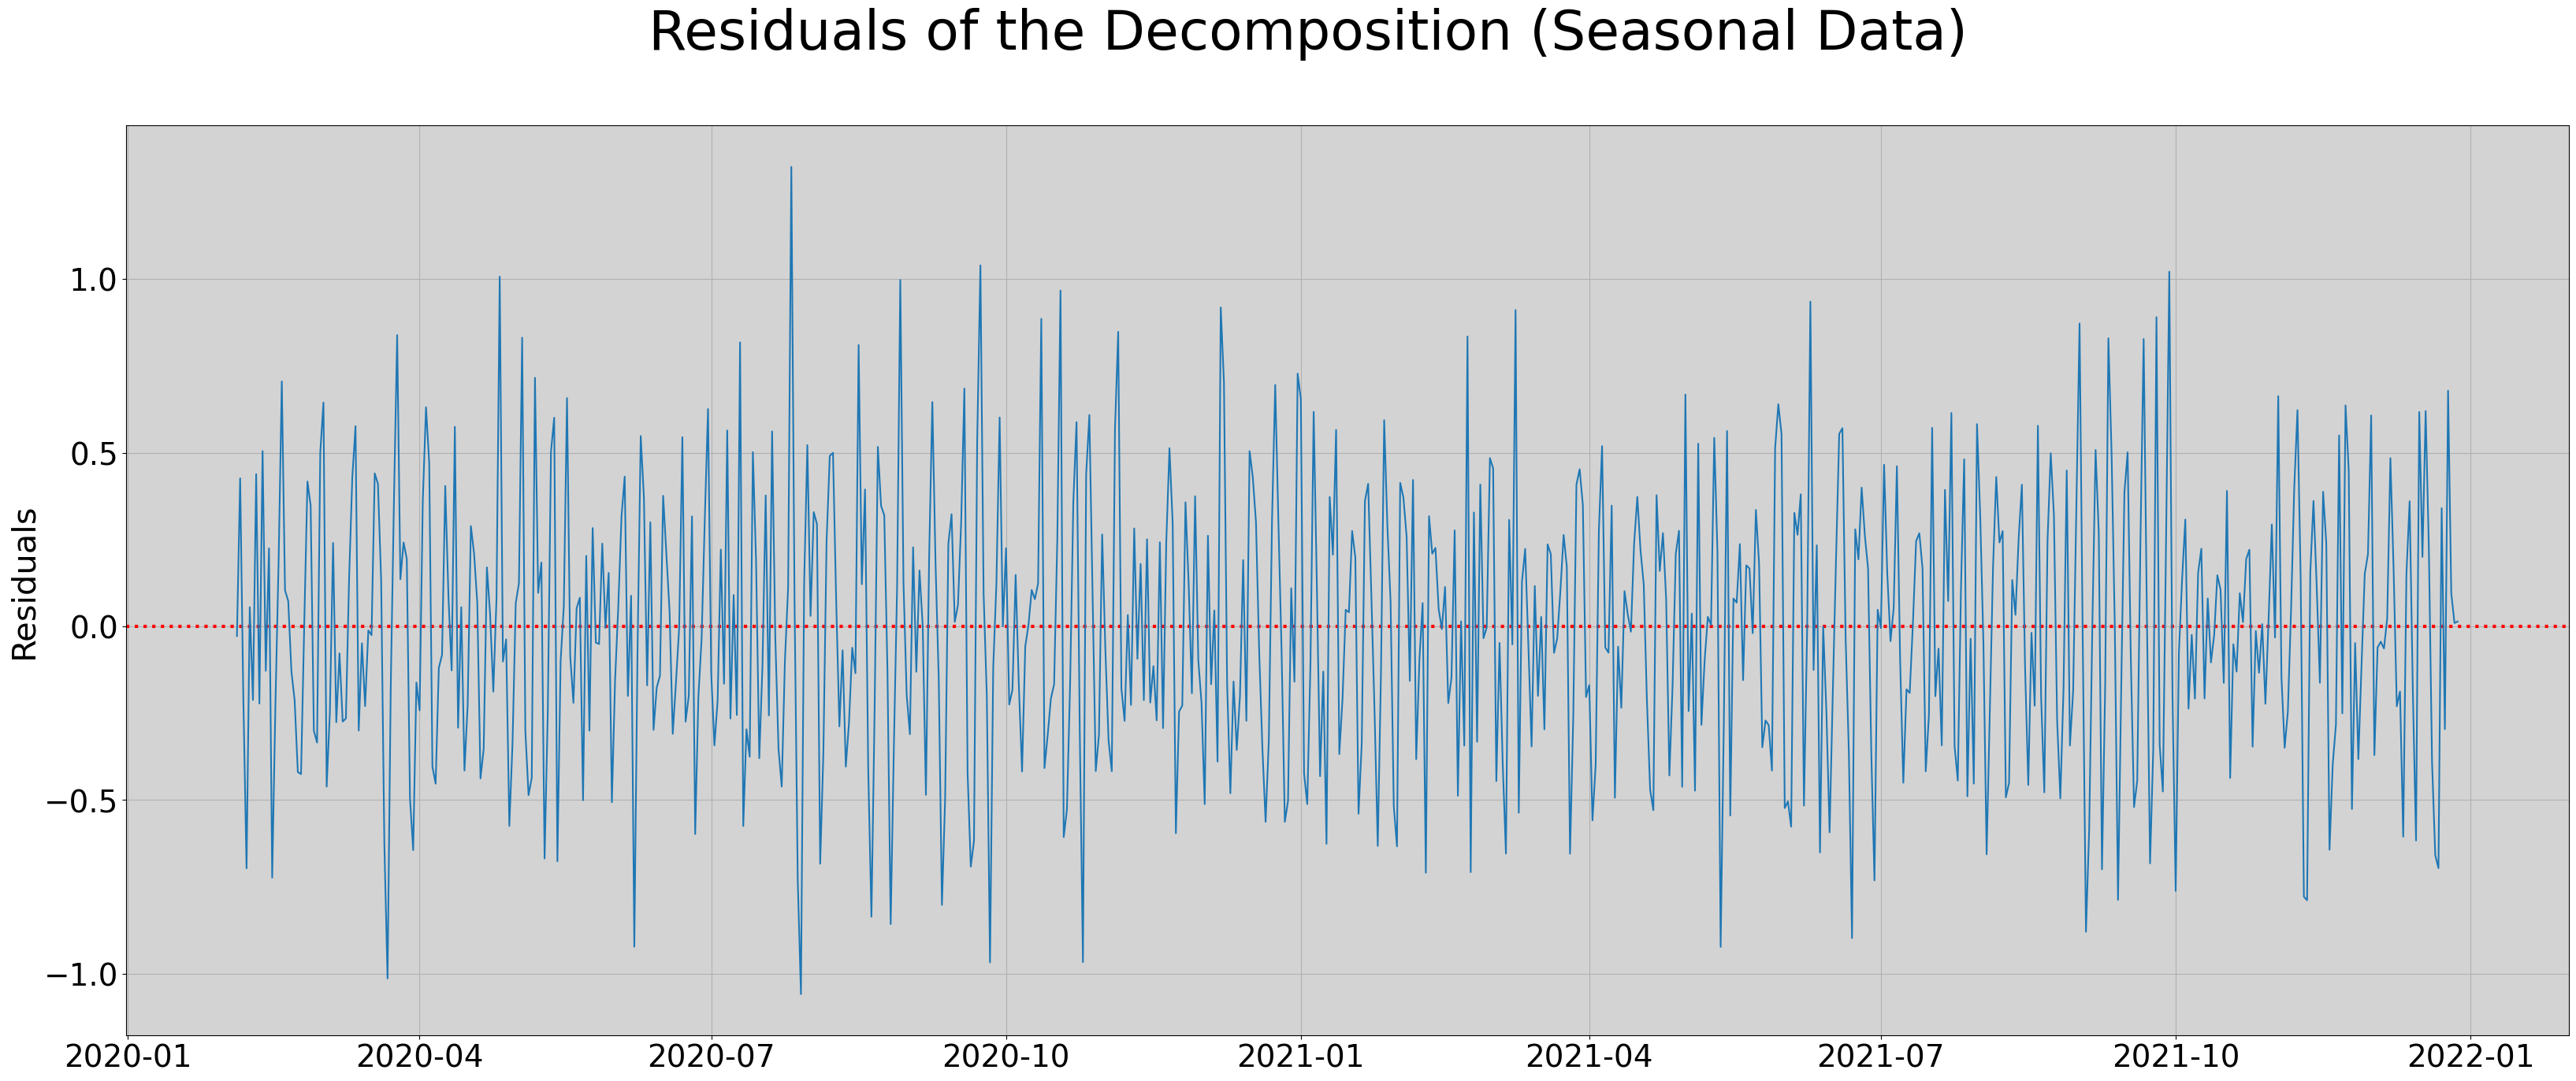

In [32]:
fig,ax = plt.subplots(1,1, figsize=(40,15))
fig.suptitle('Residuals of the Decomposition (Seasonal Data)', fontsize=50)

plt.axhline(y=0, linewidth=3, linestyle=':',color='r')
plt.ylabel("Residuals",fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.grid()
ax.set_facecolor("lightgrey")
plt.plot(seasonal_decomp.resid) 

## D2. Identification of ARIMA model.

In this section, the ARIMA model will be created.  The first attempt will use auto ARIMA using the  **auto_arima** from the **pmdarima** library. This method will try to find the optimal setting to use in creating the model  (Pulagam, 2021).

In [33]:
##Identification of ARIMA model.
pmd_auto_arima = auto_arima(train['Revenue'], trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=668.556, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=770.216, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=669.009, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=689.123, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=771.782, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=667.702, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=666.047, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=667.608, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=670.932, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=668.604, Time=0.73 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=665.764, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=689.491, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=667.336, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=667.230, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=670.4

**Print the auto ARIMA summary.**

In [34]:
# print the summary for auto arima.
pmd_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  560
Model:               SARIMAX(0, 0, 2)   Log Likelihood                -329.882
Date:                Wed, 31 Jan 2024   AIC                            665.764
Time:                        22:59:37   BIC                            678.748
Sample:                             0   HQIC                           670.834
                                - 560                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4030      0.042      9.672      0.000       0.321       0.485
ma.L2          0.2153      0.041      5.250      0.000       0.135       0.296
sigma2         0.1901      0.012     15.716      0.000       0.166       0.214
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.94   Prob(JB):                         0.44
Heteroskedasticity (H):               1.04   Skew:                            -0.08
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Note:** This is to see the results of using the auto ARIMA results in this model.  This model will be used to make any predictions going forward.

##### Fit the model and make a forecast.

In [35]:
# Forecasting using the standard ARIMA model.
arima_model = ARIMA(train['Revenue'], order=(0, 0, 2))
arima_fitted = arima_model.fit()

## D3. Forecast using the ARIMA model.

In this section there will an attempt to make a forecast or prediction using the model that was created in the previous section. The model will use the following parameters (Brownlee, 2023):

- 0 = number of lags
- 0 = order of differencing
- 2 = the moving average term

These were the parameters that were suggested in the previous section using the **auto_arima** method, and may not be what will be encountered using trial-and-error method to arrive at these values. Further detail will be given in the Word document that accompanies this Notebook. The values will be used in the order argument of the ARIMA model.  The creation of the model will be done in the next code cell.

In [36]:
# (Statsmodels.Regression.Linear_Model.OLSResults.Get_Prediction - Statsmodels 0.15.0 (+200), n.d.)

col= {'predicted_mean' : 'Revenue'}

# Will return a prediction and the prediction variance.
forecasts = arima_fitted.get_prediction(start=560, end=701, dynamic=True)

forecasts_df = pd.DataFrame(forecasts.predicted_mean)

# Rename the predicted_mean column to represent what is stored there. 
# The differences in revenue experienced on a daily basis.

forecasts_df.rename(columns=col, inplace=True)


In [37]:
# print contents.
#print(forecasts_df.head())

In [38]:
forecasts_df.sample(10)

,Revenue
2021-09-23,0.038948
2021-09-11,0.038948
2021-09-19,0.038948
2021-10-11,0.038948
2021-09-10,0.038948
2021-11-19,0.038948
2022-01-01,0.038948
2021-11-10,0.038948
2021-10-22,0.038948
2021-11-25,0.038948


In [39]:
# Create a dataframe that has the predictions and the test data.
train_forecast_df = pd.concat([train.copy(deep=True)
                               , forecasts_df.copy(deep=True)])

train_forecast_df = train_forecast_df.cumsum()


In [40]:
train_forecast_df

,Revenue,rolling_mean,rolling_std
2020-02-01,0.844888,-0.064325,-0.054439
2020-02-02,1.712347,-0.098554,-0.098138
2020-02-03,2.651099,-0.101085,-0.102493
2020-02-04,3.155846,-0.093960,-0.088080
2020-02-05,4.053808,-0.044680,0.016527
...,...,...,...
2021-12-29,26.801389,NaN,NaN
2021-12-30,26.840337,NaN,NaN
2021-12-31,26.879285,NaN,NaN
2022-01-01,26.918233,NaN,NaN


Look for the last date in the test and train and use that as a starting point.


In [41]:
row_date = train.iloc[-1]
row_date2 = test.iloc[:1]


#print("\n\nRow Data: ", row_date)
#print("\n\nRow Data: ", row_date2)

#print("\n\n Date: ",med_time_series_df.loc['2021-08-12'])

#### Extract the confidence iterval from the forecasts. 

In [42]:
confidence_int = forecasts.conf_int()


In [43]:
confidence_int

,lower Revenue,upper Revenue
2021-08-14,-0.859614,0.846945
2021-08-15,-0.876724,0.961817
2021-08-16,-0.898127,0.976023
2021-08-17,-0.898127,0.976023
2021-08-18,-0.898127,0.976023
...,...,...
2021-12-29,-0.898127,0.976023
2021-12-30,-0.898127,0.976023
2021-12-31,-0.898127,0.976023
2022-01-01,-0.898127,0.976023


**Create a row to act as astarting point to calculate the revenue for the future predictions.**

In [44]:
august_row_df = pd.DataFrame({'lower Revenue':[18.372498 ]
                              , 'upper Revenue': [18.372498], 'Date': '2021-08-12' } )

august_row_df['Date'] = pd.to_datetime(august_row_df.Date)
august_row_df.set_index('Date', inplace=True)


In [45]:
august_row_df


,lower Revenue,upper Revenue
Date,,
2021-08-12,18.372498,18.372498


In [46]:
august_row_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1 entries, 2021-08-12 to 2021-08-12
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lower Revenue  1 non-null      float64
 1   upper Revenue  1 non-null      float64
dtypes: float64(2)
memory usage: 24.0 bytes


In [47]:
confidence_int = pd.concat([august_row_df, confidence_int])

# Transform the columns back into actual revenue.
confidence_int = confidence_int.cumsum()

# Remove the first row by taking the interval not including the first row 
# in the new dataframe.
confidence_int = confidence_int.loc['2021-08-13' : '2021-12-31']


In [48]:
confidence_int

,lower Revenue,upper Revenue
2021-08-14,17.512884,19.219443
2021-08-15,16.636159,20.181260
2021-08-16,15.738033,21.157282
2021-08-17,14.839906,22.133305
2021-08-18,13.941780,23.109327
...,...,...
2021-12-27,-103.712799,150.968278
2021-12-28,-104.610925,151.944300
2021-12-29,-105.509052,152.920323
2021-12-30,-106.407178,153.896345


#### Create a visual of the predictions.

In [49]:
# Reconstitute the data for plotting.
train_revenue = train.copy(deep=True)
test_revenue = test.copy(deep=True)
revenue_df = pd.concat([train_revenue, test_revenue])

revenue_df = revenue_df.cumsum()


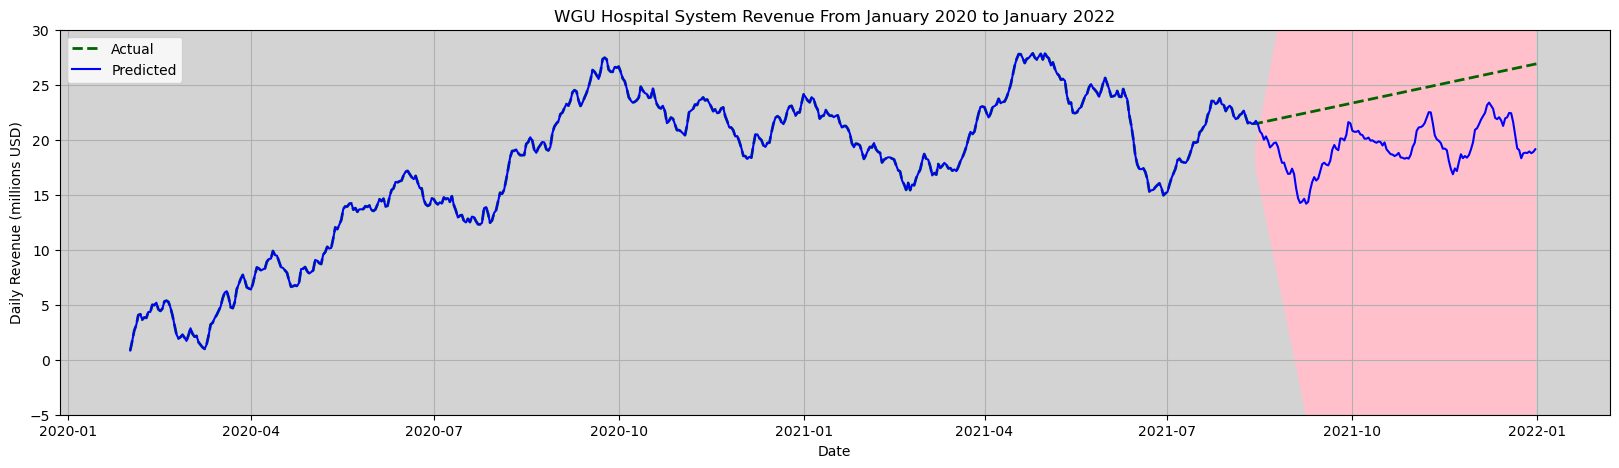

In [50]:
fig, ax = plt.subplots(1,1, figsize = [20, 5])

ax.set_facecolor('lightgray')
plt.title("WGU Hospital System Revenue From January 2020 to January 2022")
plt.xlabel('Date')
plt.ylabel("Daily Revenue (millions USD)")

# Change the limit on the y-axis to make it dispaly more appropriately.
plt.ylim(-5, 30)
plt.grid()

# plot the forecasted data
plt.plot(train_forecast_df['Revenue'], color='darkgreen'
         ,linestyle='dashed', linewidth=2)

# plot the original data.
#plt.plot(train_revenue['Revenue'], color='blue')
plt.plot(revenue_df['Revenue'], color='blue')

#Plot the confidence interval 
plt.fill_between(confidence_int.index, confidence_int['lower Revenue']
                 , confidence_int['upper Revenue'], color='pink')

plt.legend(['Actual', 'Predicted'])

plt.show()

In [51]:
# Covert to a np.array.  Issues with reading directly from the dataframes.

test =  train_forecast_df['2021-08-12':'2021-12-31']['Revenue'].to_numpy()
tot_rev =  revenue_df['2021-08-12':'2021-12-31']['Revenue'].to_numpy()


In [52]:
# mse
mse = mean_squared_error(test, tot_rev, squared=True)

In [53]:
print(f"The MSE of the model is: {round(mse, 3)}")

The MSE of the model is: 26.401


In [54]:
# rmse
root_mse = mean_squared_error(test, tot_rev, squared=False)

In [55]:
print(f"The RMSE of this model is:   {round(root_mse, 3)}")

The RMSE of this model is:   5.138


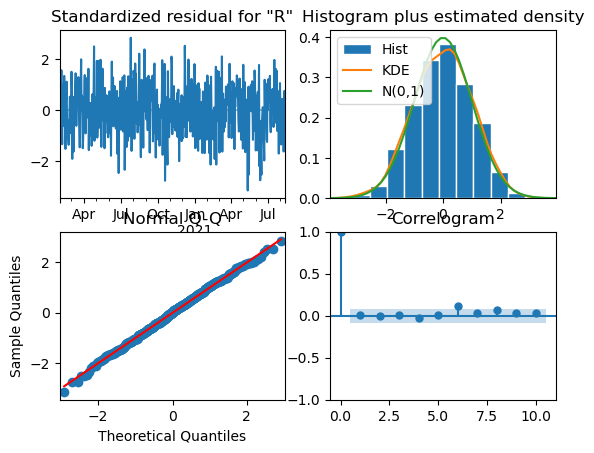

In [56]:
# Store it in a dummy to avoid two plots.
dummy = arima_fitted.plot_diagnostics()
